In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

sns.set_style('darkgrid')
sns.set_palette('icefire')

# 1. Data Retrieval

In [4]:
df_hits = pd.read_csv(r'..\data\ga_hits.csv', dtype={'session_id': 'object'})
df_hits.head(10)

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN
5,6466333295973247896.1640246168.1640246168,2021-12-23,704194.0,41,event,NaN,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,NaN,NaN
6,281215510786615563.1640245516.1640245516,2021-12-23,911854.0,102,event,NaN,sberauto.com/cars/toyota?isnew=false&rental_ca...,quiz,quiz_show,NaN,NaN
7,4024492994895054107.1640269084.1640269084,2021-12-23,1071804.0,85,event,NaN,sberauto.com/cars/all/mercedes-benz/glc/f8f330...,quiz,quiz_show,NaN,NaN
8,555009234841130092.1640256620.1640256620,2021-12-23,1013899.0,101,event,VloVXNWduHeTjUoDkjkO,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,NaN,NaN
9,2692901778487480807.1640206845.1640206845,2021-12-23,0.0,1,event,NaN,sberauto.com/cars/all/nissan/x-trail/0744675f?...,card_web,view_card,NaN,NaN


In [3]:
df_sessions = pd.read_csv(r'..\data\ga_sessions.csv', dtype={
    'session_id': 'object', 'client_id': 'object'},
                          parse_dates=[['visit_date', 'visit_time']])
df_sessions.rename(columns={'visit_date_visit_time': 'visit_dt'}, inplace=True)
df_sessions.head(10)

,visit_dt,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,2021-11-24 14:36:32,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,2021-11-14 08:21:30,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,2021-12-28 02:42:06,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,2021-05-29 05:00:00,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,2021-05-29 05:00:00,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
5,2021-05-31 12:00:00,9055447192389856083.1622453074.1622453074,2108385598.1622453075,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x812,Safari,Russia,Saint Petersburg
6,2021-12-30 08:56:28,9055455318486370642.1640843788.1640843788,2108387490.1640843602,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,PwscUHjoUJDrtfWESIHj,tablet,Android,Lenovo,NaN,602x1029,YaBrowser,Russia,Saint Petersburg
7,2021-07-12 19:00:00,9055461992850812764.1626107740.1626107740,2108389044.1626107740,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x640,Chrome,Russia,Saint Petersburg
8,2021-12-03 16:05:23,9055462349345527315.1638536723.1638536723,2108389127.1638536723,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,390x844,Safari,Russia,Moscow
9,2021-06-27 16:00:00,9055466554104774132.1624800757.1624800757,2108390106.1624800756,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x915,Chrome,Russia,Moscow


# 2. Data Understanding

## 2.1 Dataframe summary

In [4]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 17 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   visit_dt                  datetime64[ns]
 1   session_id                object        
 2   client_id                 object        
 3   visit_number              int64         
 4   utm_source                object        
 5   utm_medium                object        
 6   utm_campaign              object        
 7   utm_adcontent             object        
 8   utm_keyword               object        
 9   device_category           object        
 10  device_os                 object        
 11  device_brand              object        
 12  device_model              object        
 13  device_screen_resolution  object        
 14  device_browser            object        
 15  geo_country               object        
 16  geo_city                  object        
dtypes: datet

In [5]:
def explore_columns(df):
    for column in df.columns:
        print(f'''
    Feature: {column}
__________________________________________________________________________________________________

    Unique values counts:

    {df[column].value_counts(dropna=False)}
              
    {df[column].describe()}
    ''')

In [6]:
explore_columns(df_sessions)


    Feature: visit_dt
__________________________________________________________________________________________________

    Unique values counts:

    visit_dt
2021-06-28 22:00:00    4104
2021-09-14 09:00:00    3876
2021-05-24 10:00:00    3773
2021-05-24 13:00:00    3697
2021-05-24 12:00:00    3632
                       ... 
2021-12-25 02:09:43       1
2021-11-04 16:37:35       1
2021-12-23 00:46:38       1
2021-11-10 11:07:48       1
2021-12-31 19:39:02       1
Name: count, Length: 721817, dtype: int64
              
    count                          1860042
mean     2021-09-27 01:35:48.891483136
min                2021-05-19 10:00:00
25%                2021-08-02 15:00:00
50%                2021-10-06 18:00:00
75%                2021-11-23 13:37:28
max                2021-12-31 23:59:35
Name: visit_dt, dtype: object
    

    Feature: session_id
__________________________________________________________________________________________________

    Unique values counts:

    sess

In [7]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [7]:
explore_columns(df_hits)


    Feature: session_id
__________________________________________________________________________________________________

    Unique values counts:

    session_id
5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
                                            ... 
4570994095441102117.1630324006.1630324006      1
768506153535315810.1630314342.1630314342       1
5517253735248338264.1630315080.1630315080      1
4054272189286640867.1630334209.1630334209      1
5381267721977892188.1640271196.1640271196      1
Name: count, Length: 1734610, dtype: int64
              
    count                                      15726470
unique                                      1734610
top       5442565791571325612.1632449195.1632449195
freq                                            768
Name: session_id, dtype:

## 2.2 Add target variable and session duration to df_sessions

In [8]:
# Calculate duration of each session

df_time = df_hits[['session_id', 'hit_time']].groupby('session_id').agg(
    {'hit_time': ('min', 'max')}).reset_index()
df_time['session_duration'] = df_time[('hit_time', 'max')] - df_time[('hit_time', 'min')]
df_time.drop(columns=['hit_time'], inplace=True)
df_time.columns = df_time.columns.droplevel(1)

In [9]:
# Create dataframe with target action, total number of actions and duration for each session from df_hits

df_hits['result'] = df_hits['event_action'].apply(
    lambda x: 1 if x in [
        'sub_car_claim_click',
        'sub_car_claim_submit_click',
        'sub_open_dialog_click',
        'sub_custom_question_submit_click',
        'sub_call_number_click',
        'sub_callback_submit_click',
        'sub_submit_success',
        'sub_car_request_submit_click',
    ] else 0
)
df_to_merge = df_hits[['session_id', 'result', 'event_action']].groupby(
    'session_id').agg({'result': 'sum', 'event_action': 'count'}).reset_index()
df_to_merge = pd.merge(df_to_merge, df_time, how='left', on='session_id')
df_to_merge

,session_id,result,event_action,session_duration
0,1000009318903347362.1632663668.1632663668,0,10,NaN
1,1000010177899156286.1635013443.1635013443,0,6,238700.0
2,1000013386240115915.1635402956.1635402956,0,11,170554.0
3,1000017303238376207.1623489300.1623489300,0,12,NaN
4,1000020580299877109.1624943350.1624943350,0,1,NaN
...,...,...,...,...
1734605,999960188766601545.1626816843.1626816843,0,1,NaN
1734606,99996598443387715.1626811203.1626811203,0,2,NaN
1734607,999966717128502952.1638428330.1638428330,0,12,113657.0
1734608,999988617151873171.1623556243.1623556243,0,4,NaN


In [10]:
# Add df_hits columns and target value to df_sessions

df_sessions = pd.merge(df_sessions, df_to_merge, how='left', on='session_id')
df_sessions.dropna(subset=['result'], inplace=True)
df_sessions['target'] = df_sessions['result'].apply(lambda x: 1 if x else 0)
print(df_sessions.shape)
df_sessions.head(10)

(1732266, 21)


,visit_dt,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,result,event_action,session_duration,target
0,2021-11-24 14:36:32,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0,2.0,42927.0,0
1,2021-11-14 08:21:30,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,...,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0,1.0,0.0,0
2,2021-12-28 02:42:06,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0,16.0,111457.0,0
3,2021-05-29 05:00:00,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,...,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0,3.0,NaN,0
4,2021-05-29 05:00:00,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,...,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0,2.0,NaN,0
5,2021-05-31 12:00:00,9055447192389856083.1622453074.1622453074,2108385598.1622453075,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,Apple,NaN,375x812,Safari,Russia,Saint Petersburg,0.0,59.0,NaN,0
6,2021-12-30 08:56:28,9055455318486370642.1640843788.1640843788,2108387490.1640843602,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,PwscUHjoUJDrtfWESIHj,tablet,...,Lenovo,NaN,602x1029,YaBrowser,Russia,Saint Petersburg,0.0,6.0,505.0,0
7,2021-07-12 19:00:00,9055461992850812764.1626107740.1626107740,2108389044.1626107740,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,Samsung,NaN,360x640,Chrome,Russia,Saint Petersburg,0.0,9.0,NaN,0
8,2021-12-03 16:05:23,9055462349345527315.1638536723.1638536723,2108389127.1638536723,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,Apple,NaN,390x844,Safari,Russia,Moscow,0.0,10.0,166244.0,0
9,2021-06-27 16:00:00,9055466554104774132.1624800757.1624800757,2108390106.1624800756,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,Samsung,NaN,412x915,Chrome,Russia,Moscow,0.0,10.0,NaN,0


In [11]:
print('Number of succeful sessions after merging:', len(df_sessions[df_sessions['result'] > 0]))
print('Percentage of successful sessions:', len(df_sessions[df_sessions['result'] > 0])/len(df_sessions))

Number of succeful sessions after merging: 50314
Percentage of successful sessions: 0.02904519282835315


In [12]:
# Save df_sessions with target value to file for future use

df_sessions.to_csv(
    r'sessions_with_result.csv',
    index=False)

## 2.3 DataFrame Target Variable Distribution

Target variable distribution:

Random variable is a Bernoulli distributed variable that can take two values (0 or 1) with probabilities (p) and (1-p).
Our task is a binary classification of highly imbalanced dataset.
Our goal is to predict as many target actions as possible with the least possible damage to accuracy as could be.

In [13]:
# Load dataframe for research and training

df_new = pd.read_csv(
    r'sessions_with_result.csv',
    dtype={'session_id': 'object', 'client_id': 'object'},
    parse_dates=['visit_dt']
)
df_new.head(5)

,visit_dt,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,result,event_action,session_duration,target
0,2021-11-24 14:36:32,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0,2.0,42927.0,0
1,2021-11-14 08:21:30,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,...,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0,1.0,0.0,0
2,2021-12-28 02:42:06,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0,16.0,111457.0,0
3,2021-05-29 05:00:00,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,...,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0,3.0,NaN,0
4,2021-05-29 05:00:00,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,...,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0,2.0,NaN,0


The number of sessions with target action is very small. So let's see which groups in different columns actually contain significant number of successful sessions.

In [ ]:
cat_features = ['visit_number', 'utm_source', 'utm_medium', 'utm_campaign',
                'utm_adcontent', 'utm_keyword', 'device_category',
                'geo_country', 'geo_city']

for column in cat_features:
    print('Feature:', column)
    print('Number of unique values:', len(df_new[column].unique()))
    for group in df_new[column].unique():
        n_target_acts = len(df_new[(df_new[column] == group) & (df_new['target'] == 1)])
        if n_target_acts > 1000:
            print(f'Number of successful sessions in group {group}: {n_target_acts}')              

Conclusions: 

a) geo_country feature in its current state is not very informative since almost all of the successful sessions are in Russia. Perhaps 'Russia' could be split into smaller regions.

b) more than half of all successful sessions happen when the client first visits client's website. Still there are quite a lot of successful sessions among returning customers so we could put extra effort to use their previous activity data as predictors.

c) Moscow has almost half of all successful sessions. So probably big cities should be separated from neigbouring region.

d) In general there are few categories in most columns that contain excessive number of successful sessions as compared to the total number of unique values in the column. These should somehow be prioritized. The exact approach will be defined after closely studying each column.


## 2.4 Time trends check

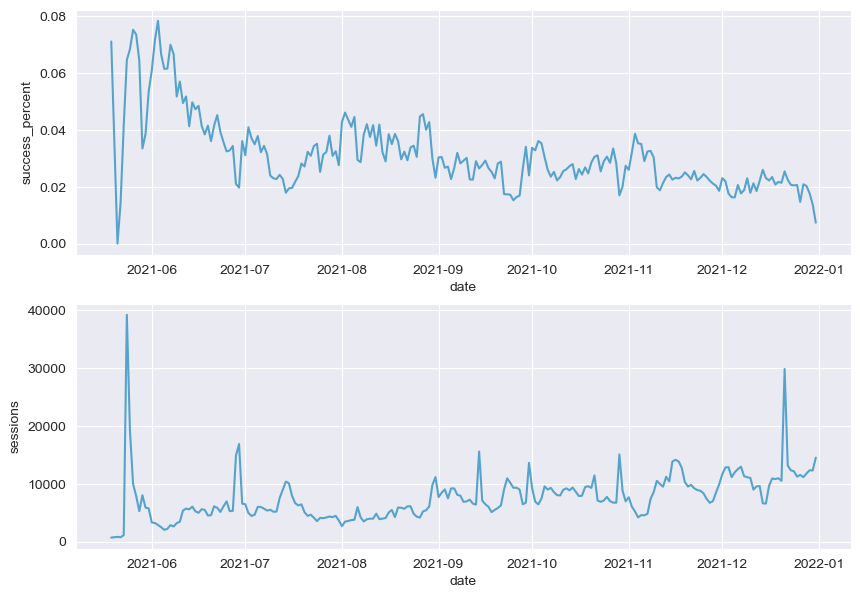

In [500]:
# Analysis per date
# Visualize downward and upward trends

df_new['date'] = df_new['visit_dt'].dt.date

tmp_date = df_new[['date', 'target', 'session_id']].groupby('date').agg({
    'target': 'sum', 'session_id': 'count'}).reset_index()
tmp_date['success_percent'] = tmp_date['target'] / tmp_date['session_id']

fig = plt.figure(figsize=(10, 7))
plt.subplot(211)
sns.lineplot(data=tmp_date, x='date', y='success_percent')

plt.subplot(212)
sns.lineplot(data=tmp_date, x='date', y='session_id')
plt.ylabel('sessions');

# 3. Data Preparation

## 3.1 Client previous behavior

(create clients previous behavior dataframe before data cleaning)

The suggestion is to split clients into first time visitors and returning clients.
We have practically no information concerning first time visitors' personal profile (except their geo_location).
That's one reason why peridicting target action is extremely complicated.

For returning clients however we could create some profile based on their previous activity (how much time they spent viewing the webpage,
how active they were in the past etc.). Supposedly these data will reflect the level of their interest in the product.
The general idea is to single out returning active clients with higher probability of target actions.
Another assumption is that a client who is actually interested in buying subscription will spend more time viewing the webpage.

### 3.1.1 Outliers function

In [501]:
def isoutlier_3sigma(df_column):
    low_threshold = df_column.mean() - 3 * df_column.std()
    high_threshold = df_column.mean() + 3 * df_column.std()
    return low_threshold, high_threshold

In [502]:
# Replace outliers with max values before creating previous behaviour dataframe

low_threshold, high_threshold = isoutlier_3sigma(df_new.result)
df_new['result'] = df_new['result'].apply(
    lambda x: x if x < high_threshold else high_threshold)

low_threshold, high_threshold = isoutlier_3sigma(df_new.event_action)
df_new['event_action'] = df_new['event_action'].apply(
    lambda x: x if x < high_threshold else high_threshold)

low_threshold, high_threshold = isoutlier_3sigma(df_new.session_duration)
df_new['session_duration'] = df_new['session_duration'].apply(
    lambda x: x if x < high_threshold else high_threshold)

print(len(df_new[df_new['result'] > high_threshold]))
print(len(df_new[df_new['event_action'] > high_threshold]))
print(len(df_new[df_new['session_duration'] > high_threshold]))

0
0
0


In [503]:
# Aggregate result and event action counts from 10 or less previous sessions for each client id   

df_prev = df_new[['client_id', 'visit_number', 'visit_dt', 'session_duration']]
df_prev.drop_duplicates(subset=['client_id', 'visit_number'], inplace=True)
new_feats = [[],[]]
for num in range(10):
    new_feats[0].append('result' + str(num + 1))
    new_feats[1].append('action' + str(num + 1))
    df_prev_tmp = df_new[['client_id', 'visit_number', 'event_action', 'result']].rename(
        columns={'result': new_feats[0][-1], 'event_action': new_feats[1][-1]})
    df_prev_tmp.drop_duplicates(subset=['client_id', 'visit_number'], inplace=True)
    df_prev_tmp['visit_number'] = df_prev_tmp['visit_number'] + num
    df_prev = pd.merge(df_prev, df_prev_tmp, how='left', on=['client_id', 'visit_number'])
    

# Calculate mean values based on existing data

df_prev['mean_result'] = df_prev[new_feats[0]].mean(axis=1)
df_prev['mean_actions'] = df_prev[new_feats[1]].mean(axis=1)

# Drop all earlier results, keep mean values

df_prev.drop(columns=new_feats[0] + new_feats[1], inplace=True)

# Offset visit_number by one to avoid data leak at merging step

df_prev['visit_number'] = df_prev['visit_number'] + 1
df_prev.rename(columns={'visit_dt': 'prev_visit', 'session_duration': 'prev_session_duration'}, inplace=True)

df_prev

,client_id,visit_number,prev_visit,prev_session_duration,mean_result,mean_actions
0,2108382700.1637753791,2,2021-11-24 14:36:32,4.292700e+04,0.0,2.0
1,210838531.1636867288,2,2021-11-14 08:21:30,0.000000e+00,0.0,1.0
2,2108385331.1640648523,2,2021-12-28 02:42:06,1.114570e+05,0.0,16.0
3,2108385564.1622255328,2,2021-05-29 05:00:00,1.082972e+06,0.0,3.0
4,2108385564.1622255328,3,2021-05-29 05:00:00,1.082972e+06,0.0,2.5
...,...,...,...,...,...,...
1729119,2108378238.1640159304,2,2021-12-22 10:48:25,1.631900e+04,0.0,2.0
1729120,2108379530.1622007305,2,2021-05-26 08:00:00,1.082972e+06,0.0,11.0
1729121,2108379955.1636979515,2,2021-11-15 15:31:55,4.511880e+05,0.0,41.0
1729122,210838164.1638189272,2,2021-11-29 15:36:44,6.793530e+05,0.0,2.0


In [504]:
# Merge original dataset with previous activity,
# then offset visit number 5 times to fill some of the values for missing visits

df_raw = df_new.copy()
df_new = pd.merge(df_new, df_prev, on=['client_id', 'visit_number'], how='left')

for num in range(6):
    df_prev['visit_number'] = df_prev['visit_number'] + 1
    df_new2 = pd.merge(df_raw, df_prev, on=['client_id', 'visit_number'], how='left')
    df_new.update(df_new2, overwrite=False)

new_cols = ['mean_result', 'mean_actions', 'prev_visit', 'prev_session_duration']

df_new['days_after_last_visit'] = (
    df_new['visit_dt'] - df_new['prev_visit']) / np.timedelta64(1,'D')
df_new[df_new.visit_number > 1][['visit_dt', 'prev_visit', 'days_after_last_visit']]

,visit_dt,prev_visit,days_after_last_visit
4,2021-05-29 05:00:00,2021-05-29 05:00:00,0.000000
10,2021-08-20 09:00:00,2021-06-27 16:00:00,53.708333
12,2021-10-01 20:00:00,2021-08-13 22:00:00,48.916667
13,2021-11-02 21:36:17,2021-10-01 20:00:00,32.066863
14,2021-11-10 18:50:15,2021-11-02 21:36:17,7.884699
...,...,...,...
1732228,2021-10-13 01:00:00,2021-10-13 00:00:00,0.041667
1732229,2021-10-13 01:00:00,2021-10-13 01:00:00,0.000000
1732242,2021-08-16 08:00:00,2021-08-15 23:00:00,0.375000
1732244,2021-08-07 11:00:00,2021-07-15 15:00:00,22.833333


In [505]:
# Random client check

df_new[df_new['client_id'] == '2108311558.1639268661'][[
    'visit_number', 'result', 'event_action', 'date'] + new_cols]

,visit_number,result,event_action,date,mean_result,mean_actions,prev_visit,prev_session_duration
1732189,1,0.0,15.000000,2021-12-12,NaN,NaN,NaT,NaN
1732190,2,0.0,6.000000,2021-12-12,0.0,15.000000,2021-12-12 03:24:34,141463.0
1732191,3,0.0,2.000000,2021-12-19,0.0,10.500000,2021-12-12 15:14:04,603.0
1732192,4,0.0,29.000000,2021-12-19,0.0,7.666667,2021-12-19 04:50:32,2355.0
1732193,5,0.0,7.000000,2021-12-19,0.0,13.000000,2021-12-19 04:50:37,135455.0
1732194,7,0.0,50.686541,2021-12-21,0.0,11.800000,2021-12-19 05:38:51,599938.0
1732195,9,0.0,1.000000,2021-12-21,0.0,18.281090,2021-12-21 04:30:09,252753.0


In [506]:
# Fill missing values and first time client empty fields 
# in columns: mean_result, mean_action and prev_session_duration
# with 0

for col in new_cols :
    df_new[col] = df_new[col].fillna(0)

# Change outliers in 'days_after_last_visit' to high threshold, then fill missing entries with maximum value

low_threshold, high_threshold = isoutlier_3sigma(df_new.days_after_last_visit)
df_new['days_after_last_visit'] = df_new['days_after_last_visit'].apply(
    lambda x: x if x < high_threshold else high_threshold)
df_new['days_after_last_visit'].fillna(df_new['days_after_last_visit'].max(), inplace=True)

# Change outliers in visit number column to high threshold value 

low_threshold, high_threshold = isoutlier_3sigma(df_new.visit_number)
df_new['visit_number'] = df_new['visit_number'].apply(lambda x: x if x < high_threshold else high_threshold)

df_new.reset_index(drop=True, inplace=True)

In [470]:
df_new[df_new.visit_number > 1].head(5)

,visit_dt,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,result,event_action,session_duration,target,date,prev_visit,prev_session_duration,mean_result,mean_actions,days_after_last_visit
4,2021-05-29 05:00:00,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2.0,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,...,0.0,2.0,1.082972e+06,0,2021-05-29,2021-05-29 05:00:00,1.082972e+06,0.0,3.000000,0.000000
10,2021-08-20 09:00:00,9055466554104774132.1629442326.1629442326,2108390106.1624800756,2.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,0.0,1.0,1.082972e+06,0,2021-08-20,2021-06-27 16:00:00,1.082972e+06,0.0,10.000000,53.708333
12,2021-10-01 20:00:00,9055469620715506713.1633110583.1633110583,2108390820.1628883993,2.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,...,0.0,3.0,1.082972e+06,0,2021-10-01,2021-08-13 22:00:00,1.082972e+06,0.0,40.000000,48.916667
13,2021-11-02 21:36:17,9055469620715506713.1635878177.1635878177,2108390820.1628883993,3.0,gVRrcxiDQubJiljoTbGm,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,...,0.0,33.0,1.938860e+05,0,2021-11-02,2021-10-01 20:00:00,1.082972e+06,0.0,21.500000,32.066863
14,2021-11-10 18:50:15,9055469620715506713.1636559415.1636559415,2108390820.1628883993,4.0,SzZERoLMmrEUEhDaYcyN,cpc,NaN,NaN,NaN,mobile,...,0.0,2.0,5.543000e+03,0,2021-11-10,2021-11-02 21:36:17,1.938860e+05,0.0,25.333333,7.884699


## 3.2 Data Cleaning

#### Plotting function

In [507]:
# Plotting functions for column values with maximum and minimum success ratio and maximum total sessions

def create_column_df(df, col_name):

    tmp = df[[col_name, 'session_id', 'target']].groupby(col_name).agg(
        {'target': 'sum', 'session_id': 'count'}).reset_index()
    tmp['success_percent'] = tmp['target']/tmp['session_id']
    tmp.rename(columns={'target': 'successful_sessions', 'session_id': 'total_sessions'},
               inplace=True)
    tmp = tmp[tmp['total_sessions'] > 50]
    return tmp

def barplot_minmax_success(df, col_name, n_min, n_max):
    
    tmp = create_column_df(df, col_name)
    plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
    

    plot_max = tmp.nlargest(n_max, 'success_percent')
    plot_min = tmp.nsmallest(n_min, 'success_percent')
    print(pd.concat([plot_min, plot_max], axis=0).to_markdown())

    plt.subplot(121)
    sns.barplot(plot_min, x=col_name, y='success_percent')
    plt.xticks(rotation=45)
    plt.title(f'The Least Successful Groups in {col_name}')
    plt.ylabel('success probability')
    plt.xlabel('')

    plt.subplot(122)
    sns.barplot(plot_max, x=col_name, y='success_percent')
    plt.xticks(rotation=45)
    plt.title(f'The Most Successful Groups in {col_name}')
    plt.ylabel('success probability')
    plt.xlabel('');

def barplot_max_total_sessions(df, col_name, num):
    
    tmp = create_column_df(df, col_name)
    fig = plt.figure(figsize=(12, 5))

    plot_data = tmp.nlargest(num, 'total_sessions')
    print(plot_data.to_markdown())
    
    sns.barplot(plot_data, x=col_name, y='success_percent')
    plt.xticks(rotation=45)
    plt.title(f'Success probabilities in {col_name} groups with highest number of sessions')
    plt.ylabel('success probability')
    plt.xlabel('');

### 3.2.1 Delete duplicates and useless data

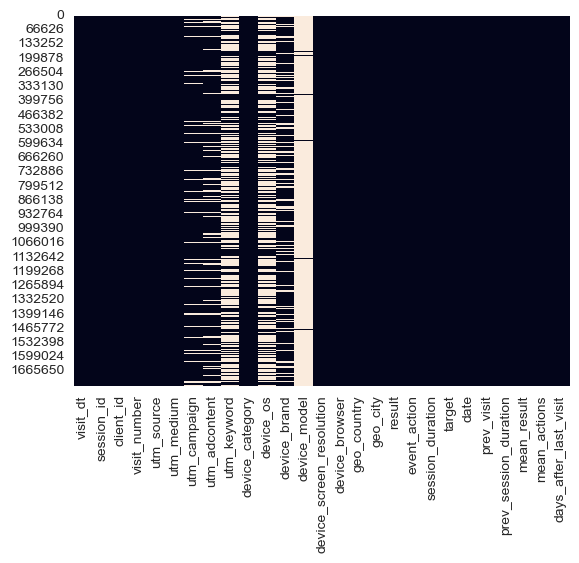

In [370]:
# Null values map

sns.heatmap(df_new.isnull(), cbar=False);

In [371]:
# Search for columns missing over 30% of entries

for column in df_new.columns:
    NA_percent = len(df_new[df_new[column].isna()]) / len(df_new)
    if NA_percent > 0.3:
        print(f'Percentage of missing values in column {column}: {NA_percent}')

Percentage of missing values in column utm_keyword: 0.589258231703445
Percentage of missing values in column device_os: 0.58533966492444
Percentage of missing values in column device_model: 0.9913050305207168


|     | utm_keyword          |   successful_sessions |   total_sessions |   success_percent |
|----:|:---------------------|----------------------:|-----------------:|------------------:|
| 957 | puhZPIYqKXeFPaUviSjo |                 11185 |           465950 |        0.0240047  |
| 605 | aXQzDWsJuGXeBXexNHjc |                    73 |            18154 |        0.00402115 |
| 185 | ITfrGJNwVsHBGJMAKoct |                   322 |            12395 |        0.0259782  |
| 934 | pHqgLcdBQPSLcrTpLkdr |                   112 |            12320 |        0.00909091 |
| 747 | hAmNSZmQkKQKAjZEGlgb |                   349 |            10422 |        0.0334869  |
| 456 | UKNBOHebRIIsQRsjNKay |                   305 |            10287 |        0.0296491  |
| 178 | IGUCNvHlhfHpROGclCit |                   107 |             6950 |        0.0153957  |
| 405 | RkpOyeEPgcMBSDuHLQcj |                   112 |             6648 |        0.0168472  |
| 209 | JajANoFxoqXfKRNBUhzx |                   159 |      

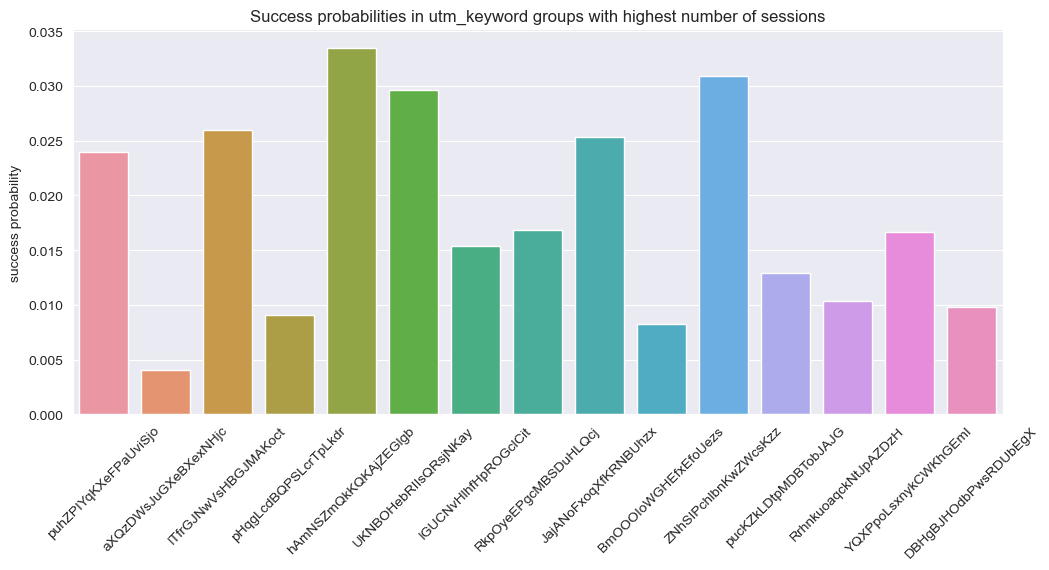

In [372]:
# Visualize utm_keyword influence on target_action for most frequent keywords

barplot_max_total_sessions(df_new, 'utm_keyword', 15)

Columns 'device_model' and 'device_os' can be safely dropped.
Values in column 'utm_keyword' are fewer than the recommended threshold
but if available those could be critical for predicting target action.
So suggested strategy is to keep this column for future use.

In [508]:
# Drop columns with too many missing values and session_id

df_new = df_new.drop(columns=['device_model', 'device_os'])
df_new.head(5)

,visit_dt,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,result,event_action,session_duration,target,date,prev_visit,prev_session_duration,mean_result,mean_actions,days_after_last_visit
0,2021-11-24 14:36:32,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,0.0,2.0,4.292700e+04,0,2021-11-24,0,0.000000e+00,0.0,0.0,57.609902
1,2021-11-14 08:21:30,905544597018549464.1636867290.1636867290,210838531.1636867288,1.0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,...,0.0,1.0,0.000000e+00,0,2021-11-14,0,0.000000e+00,0.0,0.0,57.609902
2,2021-12-28 02:42:06,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,0.0,16.0,1.114570e+05,0,2021-12-28,0,0.000000e+00,0.0,0.0,57.609902
3,2021-05-29 05:00:00,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1.0,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,...,0.0,3.0,1.082972e+06,0,2021-05-29,0,0.000000e+00,0.0,0.0,57.609902
4,2021-05-29 05:00:00,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2.0,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,...,0.0,2.0,1.082972e+06,0,2021-05-29,2021-05-29 05:00:00,1.082972e+06,0.0,3.0,0.000000


In [374]:
# Check for duplicates

df_new[df_new.duplicated()]

,visit_dt,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,result,event_action,session_duration,target,date,prev_visit,prev_session_duration,mean_result,mean_actions,days_after_last_visit


### 3.2.2 Fill missing Data

In [509]:
# Check for NA values in columns

cols_with_NA = [(col, len(df_new[df_new[col].isna()])) 
                for col in df_new.columns if len(df_new[df_new[col].isna()]) != 0]
print('Number of missing values per column')
print(cols_with_NA)

Number of missing values per column
[('utm_source', 76), ('utm_campaign', 195287), ('utm_adcontent', 304137), ('utm_keyword', 1020752), ('device_brand', 347196)]


#### a) utm_source

Very few missing values in utm_source can be dropped.

In [376]:
df_new.utm_source.describe()

count                  1732190
unique                     280
top       ZpYIoDJMcFzVoPFsHGJL
freq                    552555
Name: utm_source, dtype: object

In [510]:
# Delete NA values

df_new = df_new[df_new['utm_source'].notna()]

#### b) utm_campaign, utm_adcontent, utm_keyword

Number of missing values in these three columns is quite high so these cannot be safely dropped.
they will be replaced with the general value '(not set)' since this value is already used in Google Analytics
and is present in these columns.

In [378]:
df_new.utm_campaign.describe()

count                  1536903
unique                     406
top       LTuZkdKfxRGVceoWkVyg
freq                    422965
Name: utm_campaign, dtype: object

In [379]:
df_new.utm_adcontent.describe()

count                  1428089
unique                     280
top       JNHcPlZPxEMWDnRiyoBf
freq                    935368
Name: utm_adcontent, dtype: object

In [380]:
df_new.utm_keyword.describe()

count                   711438
unique                    1192
top       puhZPIYqKXeFPaUviSjo
freq                    465910
Name: utm_keyword, dtype: object

In [511]:
# Fill NA values with '(not set)'

df_new[['utm_campaign', 'utm_adcontent', 'utm_keyword']] = df_new[
    ['utm_campaign', 'utm_adcontent', 'utm_keyword']
].fillna('(not set)')

#### c) device_brand

There is an opportunity to fill some of the missing brand values based on the general knowledge that Safari is the main browser for Apple devices.

In [382]:
df_new.device_brand.describe()

count     1385042
unique        200
top         Apple
freq       503526
Name: device_brand, dtype: object

In [383]:
# Check if NAs can be safely replaced with Apple if browser is set to Safari

print('Количество устройств с браузером Safari, кроме Apple:', len(
    df_new[df_new['device_brand'].notna() & (df_new['device_brand'] != 'Apple')
    & (df_new.device_browser == 'Safari')]))
print('Количество устройств Apple с браузером Safari:', len(
    df_new[(df_new['device_brand'] == 'Apple') & (df_new.device_browser == 'Safari')]))

df_new[df_new['device_brand'].notna() & (df_new['device_brand'] != 'Apple')
& (df_new.device_browser == 'Safari')][['device_brand', 'device_category', 'device_browser']]

Количество устройств с браузером Safari, кроме Apple: 11
Количество устройств Apple с браузером Safari: 397922


,device_brand,device_category,device_browser
10437,Nokia,mobile,Safari
26908,(not set),mobile,Safari
55554,Nokia,mobile,Safari
65784,Nokia,mobile,Safari
900215,(not set),mobile,Safari
1016083,Microsoft,mobile,Safari
1141719,Nokia,mobile,Safari
1182851,(not set),mobile,Safari
1311882,(not set),mobile,Safari
1392607,(not set),mobile,Safari


In [512]:
# Fill NA values for Safari with Apple. Use '(not set)' as fill_value
# for all other rows since it already exists in the dataset

df_new.device_brand = df_new.device_brand.fillna('(not set)')

for index, row in df_new[df_new['device_brand'] == '(not set)'].iterrows():
    if row['device_browser'] == 'Safari':
        df_new.loc[index, 'device_brand'] = 'Apple'

In [513]:
# Doublecheck for NA values

cols_with_NA = [(col, len(df_new[df_new[col].isna()])) 
                for col in df_new.columns if len(df_new[df_new[col].isna()]) != 0]
print(cols_with_NA)

[]


In [514]:
df_new.reset_index(drop=True, inplace=True)

## 3.3 Data Types

Data types were specified at data retrieval.

In [315]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732190 entries, 0 to 1732189
Data columns (total 25 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   visit_dt                  datetime64[ns]
 1   session_id                object        
 2   client_id                 object        
 3   visit_number              float64       
 4   utm_source                object        
 5   utm_medium                object        
 6   utm_campaign              object        
 7   utm_adcontent             object        
 8   utm_keyword               object        
 9   device_category           object        
 10  device_brand              object        
 11  device_screen_resolution  object        
 12  device_browser            object        
 13  geo_country               object        
 14  geo_city                  object        
 15  result                    float64       
 16  event_action              float64       
 17  session_

### 3.3.1 Transform date column to numeric type

In [515]:
df_new['date'] = df_new['date'].apply(lambda x: (int(str(x).split("-")[0]) * 365 +
                                                     int(str(x).split("-")[1]) * 30 +
                                                     int(str(x).split("-")[2])))

## 3.4 Feature Engineering

### 3.4.1 New time related features: day, weekday_hour, days_since_ad_start

For time related data the possible features are date, day of month, day of week, time, time per day of week.
Considering that we have already found that success probability depends on the date (downward success probability trend specified above)
it is important to keep the date.
In this case feautres like day of month and day of week seem superfluous and might even be contradictory to the general trend.
So they will not be used for prediction.
Time feature can be used but it does not provide any significant increase or decrease in success probability (see diagrams below).
For this reason it will also be dropped.

In [516]:
# Create df with time-related features

tmp_dt = df_new[['session_id', 'visit_dt', 'visit_number', 'target']]
tmp_dt['hour'] = tmp_dt['visit_dt'].dt.hour
tmp_dt['weekday'] = tmp_dt['visit_dt'].dt.day_name()
tmp_dt.head(5)

,session_id,visit_dt,visit_number,target,hour,weekday
0,9055434745589932991.1637753792.1637753792,2021-11-24 14:36:32,1.0,0,14,Wednesday
1,905544597018549464.1636867290.1636867290,2021-11-14 08:21:30,1.0,0,8,Sunday
2,9055446045651783499.1640648526.1640648526,2021-12-28 02:42:06,1.0,0,2,Tuesday
3,9055447046360770272.1622255328.1622255328,2021-05-29 05:00:00,1.0,0,5,Saturday
4,9055447046360770272.1622255345.1622255345,2021-05-29 05:00:00,2.0,0,5,Saturday


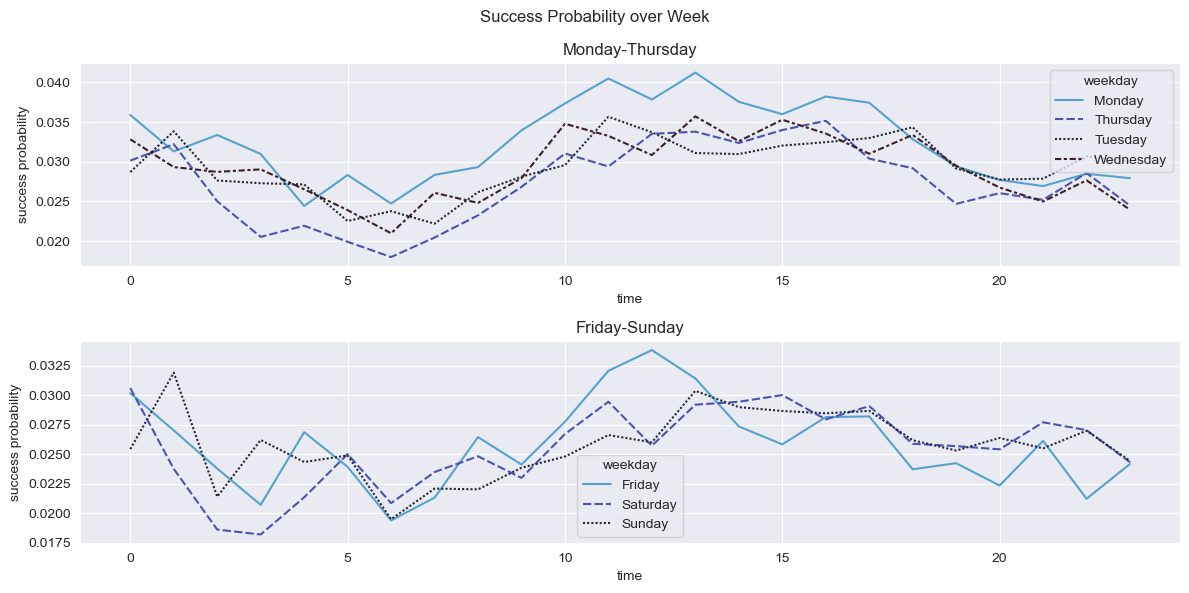

In [517]:
# Explore day periods influence on success probability
# Group by weekday and calculate success percentage per hour

tmp_w_h = tmp_dt[['weekday', 'hour', 'target']].groupby(['hour', 'weekday'])['target'].agg(
    ['sum','count']).reset_index()
tmp_w_h['success_percent'] = tmp_w_h['sum']/tmp_w_h['count']

# Create pivot_table for seaborn

pivot_workdays = tmp_w_h[(tmp_w_h['weekday'] != 'Sunday') & (
    tmp_w_h['weekday'] != 'Saturday') & (
    tmp_w_h['weekday'] != 'Friday')].pivot(
    index='hour', columns='weekday', values='success_percent')
pivot_weekend = tmp_w_h[(tmp_w_h['weekday'] == 'Sunday') | (
    tmp_w_h['weekday'] == 'Saturday') | (
    tmp_w_h['weekday'] == 'Friday')].pivot(
    index='hour', columns='weekday', values='success_percent')

# Plot

fig = plt.figure(figsize=(12, 6))
plt.suptitle('Success Probability over Week')

plt.subplot(211)
sns.lineplot(pivot_workdays)
plt.title('Monday-Thursday')
plt.ylabel('success probability')
plt.xlabel('time')

plt.subplot(212)
sns.lineplot(pivot_weekend)
plt.title('Friday-Sunday')
plt.ylabel('success probability')
plt.xlabel('time')
plt.tight_layout();

### 3.4.2 New feature: days_since_ad_st

The assumption is that there is a time gap for most people between the moment they first see an advertisement and their final decision to proceed to target actions. Another assumption is that that when advertisment has been present for quite a while it attracts less and less audience seriously interested in the product.

In [518]:
# For each advertisement calculate number of days since its publication

ad_start_dates = {}
for ad in df_new.utm_adcontent.unique():
    ad_start = df_new[df_new.utm_adcontent == ad].visit_dt.min()
    ad_start_dates[ad] = ad_start
    
df_new['ad_start_tmp'] = df_new.utm_adcontent.apply(lambda x: ad_start_dates.get(x))
df_new['days_since_ad_st'] = round((df_new.visit_dt - df_new.ad_start_tmp) / np.timedelta64(1,'D'))
df_new['days_since_ad_st'].fillna(df_new['days_since_ad_st'].median(), inplace=True)

# Change outliers to high_threshold

low_threshold, high_threshold = isoutlier_3sigma(df_new.days_since_ad_st)
df_new['days_since_ad_st'] = df_new['days_since_ad_st'].apply(
    lambda x: x if x < high_threshold else high_threshold)
df_new[['target', 'days_since_ad_st']].corr()

,target,days_since_ad_st
target,1.000000,-0.013854
days_since_ad_st,-0.013854,1.000000


|     |   days_since_ad_st |   successful_sessions |   total_sessions |   success_percent |
|----:|-------------------:|----------------------:|-----------------:|------------------:|
|   5 |                  5 |                  2485 |            46012 |         0.0540077 |
|   6 |                  6 |                  1609 |            29624 |         0.0543141 |
|  41 |                 41 |                   477 |            24747 |         0.0192751 |
| 216 |                216 |                   638 |            23243 |         0.0274491 |
|  40 |                 40 |                   465 |            20738 |         0.0224226 |
|   7 |                  7 |                   848 |            17296 |         0.0490287 |
|  18 |                 18 |                   402 |            16762 |         0.0239828 |
|   8 |                  8 |                   730 |            14519 |         0.0502789 |
|  24 |                 24 |                   442 |            14036 |         

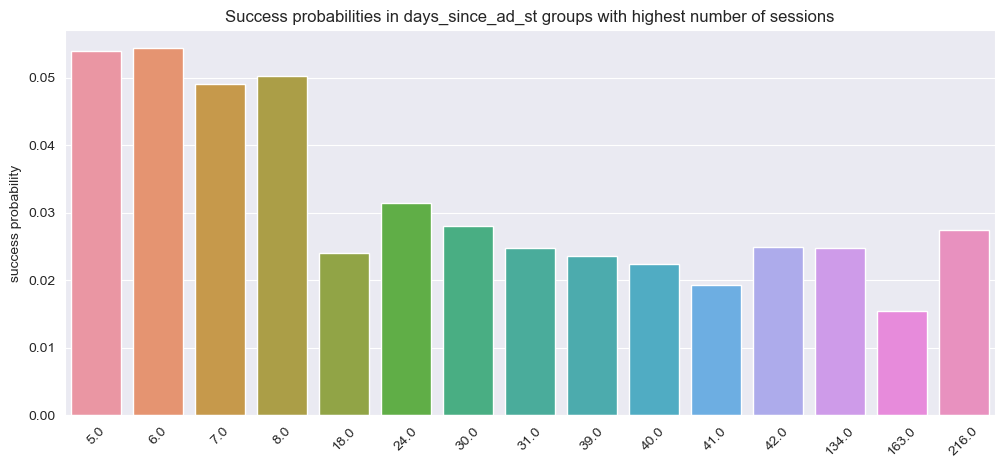

In [391]:
barplot_max_total_sessions(df_new, 'days_since_ad_st', 15)

Unfortunately these data are somewhat confusing (higher success ratio for over 100 days old ads). Supposedly the confusion comes from repetitive usage of the same adcontents over several marketing campaigns. This new feature is not as valuable as it could be but we shall keep it for the time being.

#### b) utm_source, utm_adcontent, utm_medium, utm_campaign, utm_keyword

|     | utm_source           |   successful_sessions |   total_sessions |   success_percent |
|----:|:---------------------|----------------------:|-----------------:|------------------:|
|  10 | CFeqZLBNQdYHxJrTOHjY |                     0 |               86 |       0           |
|  94 | QYfbqJXuLdJGfOSFgZOs |                     0 |               57 |       0           |
| 116 | TxKUcPpthBDPieTGmVhx |                     0 |             2024 |       0           |
| 172 | eYRDXZIocNyHVjEHzesr |                     0 |               65 |       0           |
| 184 | fgymSoTvjKPEgaIJqsiH |                     0 |             9557 |       0           |
| 185 | gDBGzjFKYabGgSPZvrDH |                     2 |            13331 |       0.000150026 |
| 225 | nmfptFmSirEqNzAzqbXA |                     2 |             2197 |       0.000910332 |
| 181 | fbFKcMumlScApQMqFIqp |                     1 |              947 |       0.00105597  |
|  63 | LIWKeifdTCbuNeniIUqm |                    17 |      

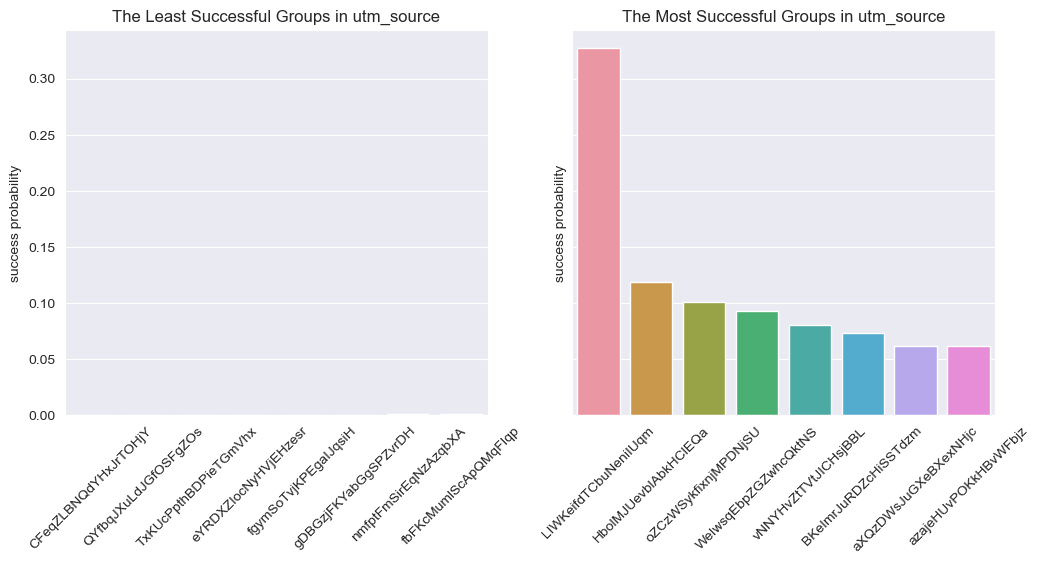

In [392]:
barplot_minmax_success(df_new, 'utm_source', 8, 8)

|     | utm_source           |   successful_sessions |   total_sessions |   success_percent |
|----:|:---------------------|----------------------:|-----------------:|------------------:|
| 149 | ZpYIoDJMcFzVoPFsHGJL |                 15998 |           552555 |       0.0289528   |
| 176 | fDLlAcSmythWSCVMvqvL |                 10531 |           277060 |       0.0380098   |
| 210 | kjsLglQLzykiRbcDiGcD |                  6293 |           245178 |       0.0256671   |
|  77 | MvfHsxITijuriZxsqZqt |                  2249 |           175831 |       0.0127907   |
|   5 | BHcvLfOaCWvWTykYqHVe |                  3882 |           110963 |       0.0349846   |
| 156 | bByPQxmDaMXgpHeypKSM |                  5557 |            90356 |       0.0615012   |
|  96 | QxAxdyPLuQMEcrdZWdWb |                  1404 |            45267 |       0.031016    |
| 153 | aXQzDWsJuGXeBXexNHjc |                  1827 |            29528 |       0.0618735   |
| 205 | jaSOmLICuBzCFqHfBdRg |                   401 |      

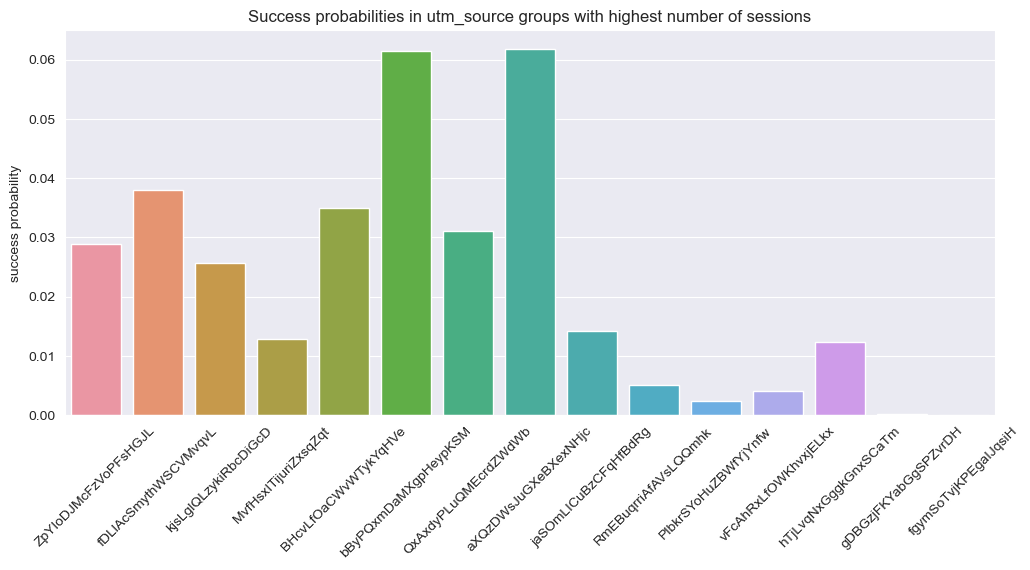

In [393]:
barplot_max_total_sessions(df_new, 'utm_source', 15)

|    | utm_medium      |   successful_sessions |   total_sessions |   success_percent |
|---:|:----------------|----------------------:|-----------------:|------------------:|
|  6 | blogger_header  |                     2 |              760 |        0.00263158 |
| 19 | info_text       |                     2 |              335 |        0.00597015 |
|  7 | blogger_stories |                    35 |             4226 |        0.00828206 |
|  2 | app             |                    11 |             1211 |        0.0090834  |
| 31 | partner         |                     1 |               95 |        0.0105263  |
| 13 | cpm             |                  2519 |           229791 |        0.0109621  |
| 45 | stories         |                   126 |            10472 |        0.0120321  |
| 47 | tg              |                    51 |             3920 |        0.0130102  |
| 23 | link            |                    17 |               52 |        0.326923   |
| 20 | landing         |        

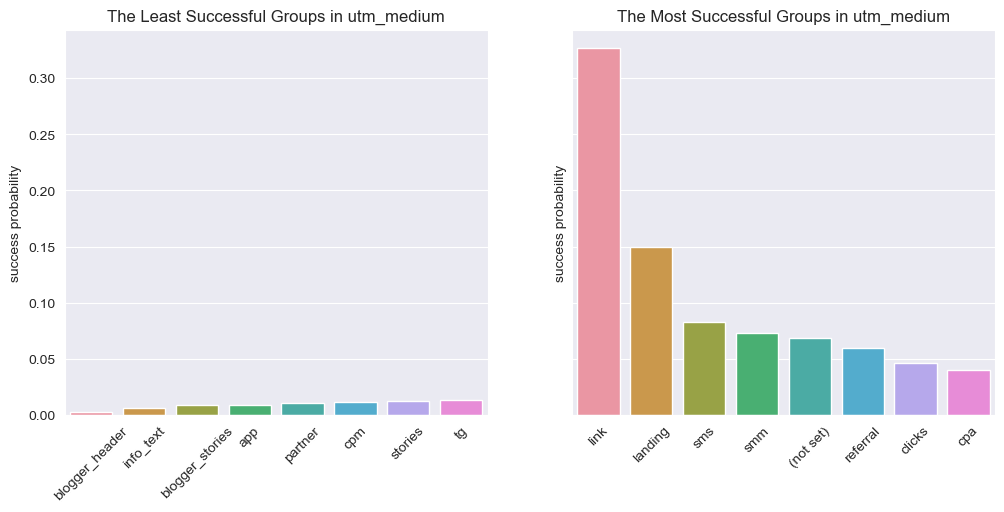

In [394]:
barplot_minmax_success(df_new, 'utm_medium', 8, 8)

|    | utm_medium      |   successful_sessions |   total_sessions |   success_percent |
|---:|:----------------|----------------------:|-----------------:|------------------:|
|  4 | banner          |                 15107 |           525206 |        0.028764   |
| 12 | cpc             |                  9529 |           399395 |        0.0238586  |
|  0 | (none)          |                 10531 |           277060 |        0.0380098  |
| 13 | cpm             |                  2519 |           229791 |        0.0109621  |
| 38 | referral        |                  8181 |           136851 |        0.0597803  |
| 29 | organic         |                  2100 |            55009 |        0.0381756  |
| 16 | email           |                   401 |            28287 |        0.0141761  |
| 34 | push            |                   840 |            27710 |        0.030314   |
| 45 | stories         |                   126 |            10472 |        0.0120321  |
| 14 | cpv             |        

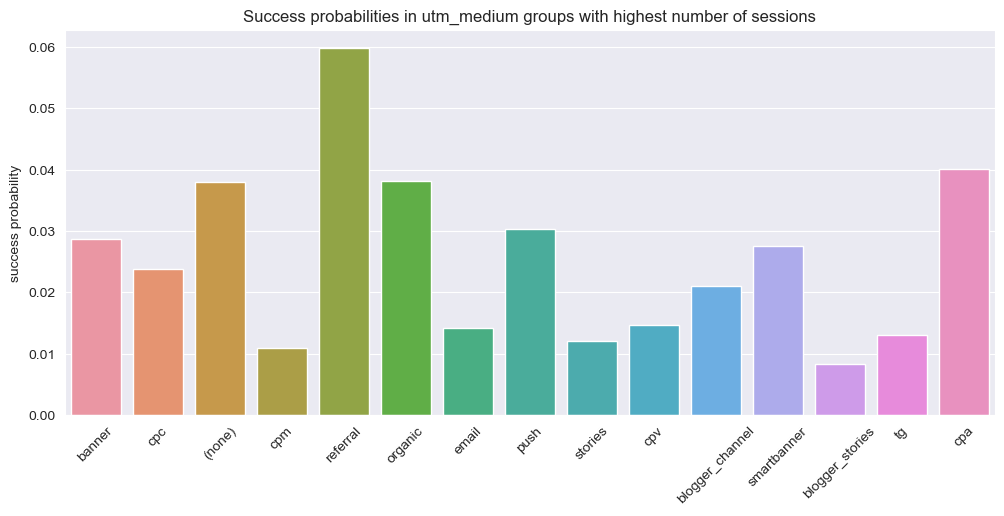

In [395]:
barplot_max_total_sessions(df_new, 'utm_medium', 15)

|     | utm_campaign         |   successful_sessions |   total_sessions |   success_percent |
|----:|:---------------------|----------------------:|-----------------:|------------------:|
|  36 | EvhrtRzIJnQYHziPiLzV |                     0 |             1201 |         0         |
|  38 | FNCczGzZUTzZVolDcPyC |                     0 |              142 |         0         |
|  41 | FhMPkFqqAboknIypeYDz |                     0 |              124 |         0         |
|  46 | GboXzNKRyCWKEtblNdau |                     0 |              128 |         0         |
|  52 | HKUDoNXhPeIzUdnZpRdl |                     0 |              207 |         0         |
|  55 | HtyIDWOBgqXsGucSiffW |                     0 |               75 |         0         |
|  60 | ISrKoXQCxqqYvAZICvjs |                     0 |               87 |         0         |
| 294 | lndNIerCYECRQvBTyTye |                    23 |               75 |         0.306667  |
| 241 | emlBaVkgLVRqbEVOSSXt |                   145 |      

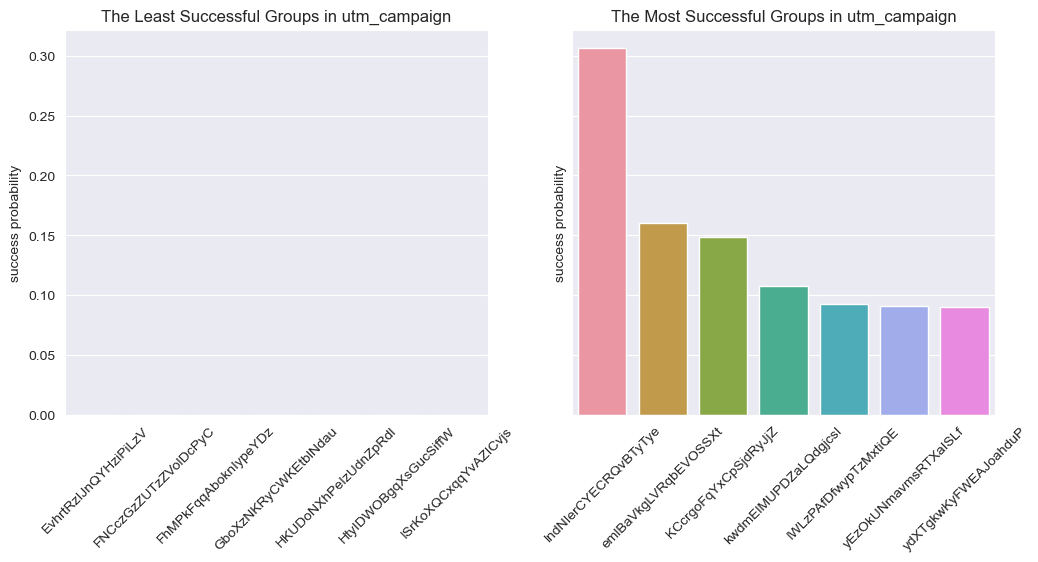

In [396]:
barplot_minmax_success(df_new, 'utm_campaign', 7, 7)

|     | utm_campaign         |   successful_sessions |   total_sessions |   success_percent |
|----:|:---------------------|----------------------:|-----------------:|------------------:|
|  88 | LTuZkdKfxRGVceoWkVyg |                 19004 |           422965 |        0.0449304  |
|  85 | LEoPHuyFvzoNfnzGgfcd |                  9348 |           321286 |        0.0290956  |
|  40 | FTjNLDyTrXaWYgZymFkV |                  2447 |           234950 |        0.010415   |
|   0 | (not set)            |                  7174 |           195287 |        0.0367357  |
| 256 | gecBYcKZCPMcVYdSSzKP |                  4545 |           133247 |        0.0341096  |
| 193 | XHNUiSKKGTEpSAlaVMFQ |                   401 |            23750 |        0.0168842  |
| 348 | sbJRYgVfvcnqKJNDDYIr |                   575 |            19942 |        0.0288336  |
| 317 | okTXSMadDkjvntEHzIjp |                    77 |            18405 |        0.00418365 |
|  93 | LwJZxKuWmvOhPsaCeRjG |                   285 |      

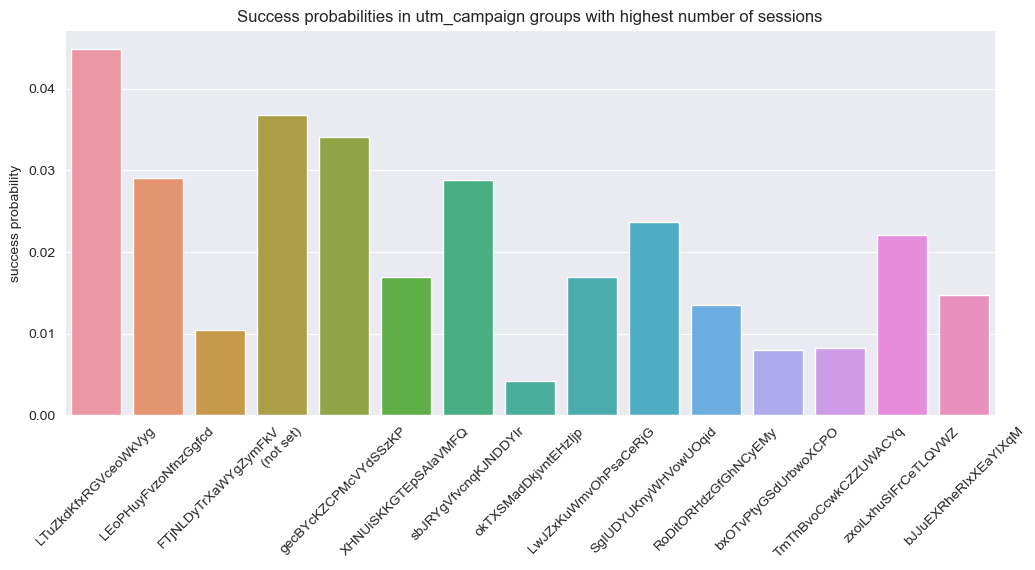

In [397]:
barplot_max_total_sessions(df_new, 'utm_campaign', 15)

|     | utm_adcontent        |   successful_sessions |   total_sessions |   success_percent |
|----:|:---------------------|----------------------:|-----------------:|------------------:|
|   4 | AbzcnvSMiZVQpjoceeKU |                     0 |              275 |         0         |
|  16 | DaehHXyBdjcdSRnPiAQn |                     0 |              478 |         0         |
|  38 | HhkEQvDgekUQWMWUpfqW |                     0 |              162 |         0         |
|  58 | LcGIUNPUAmXtQJaDfFBR |                     0 |             2026 |         0         |
|  70 | NUkWLMZGFsiVUNEECwyd |                     0 |               55 |         0         |
| 122 | WvCMRUAbanZQkQfWaSEa |                     0 |              123 |         0         |
| 145 | bOQwsecsGWEGaGQIaBDu |                     0 |              176 |         0         |
| 176 | htRZUQDANvNrHaxZjsjz |                     6 |               91 |         0.0659341 |
| 116 | WAeycgIqKXoOMXPzDUDX |                    49 |      

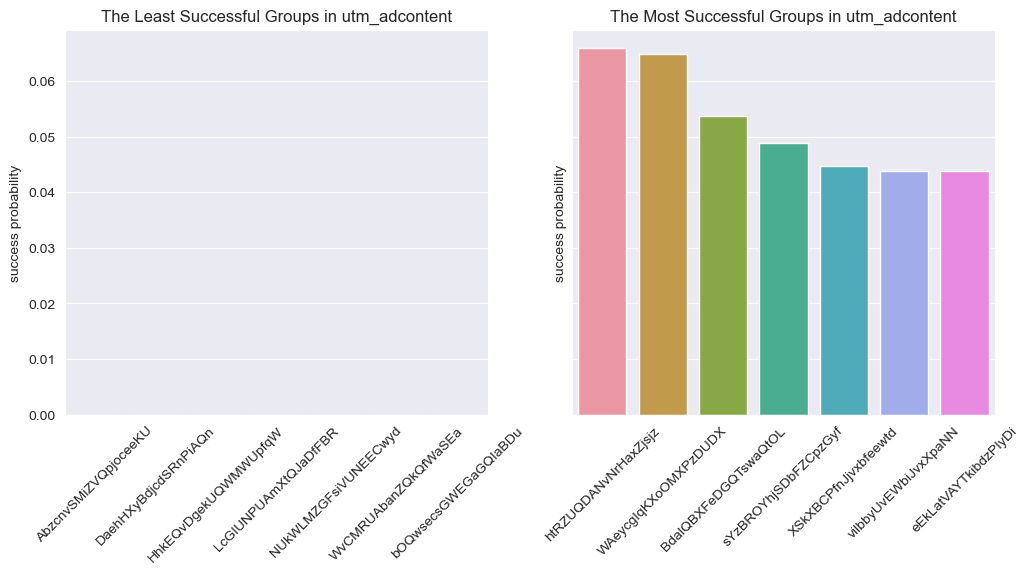

In [398]:
barplot_minmax_success(df_new, 'utm_adcontent', 7, 7)

|     | utm_adcontent        |   successful_sessions |   total_sessions |   success_percent |
|----:|:---------------------|----------------------:|-----------------:|------------------:|
|  46 | JNHcPlZPxEMWDnRiyoBf |                 33961 |           935368 |       0.0363076   |
|   0 | (not set)            |                  8750 |           304101 |       0.0287733   |
| 245 | vCIpmpaGBnIQhyYNkXqp |                  3911 |           179438 |       0.0217958   |
| 264 | xhoenQgDQsgfEPYNPwKO |                  1272 |           104381 |       0.0121861   |
|  83 | PkybGvWbaqORmxjNunqZ |                   978 |            59038 |       0.0165656   |
|  57 | LLfCasrxQzJIyuldcuWy |                    72 |            18138 |       0.00396957  |
| 105 | TuyPWsGQruPMpKvRxeBF |                     2 |            17884 |       0.000111832 |
| 110 | UxrnyMlRBSOhOjytXnMG |                     2 |            13349 |       0.000149824 |
| 150 | dUuXlWzvmhDSyclWRhNP |                    55 |      

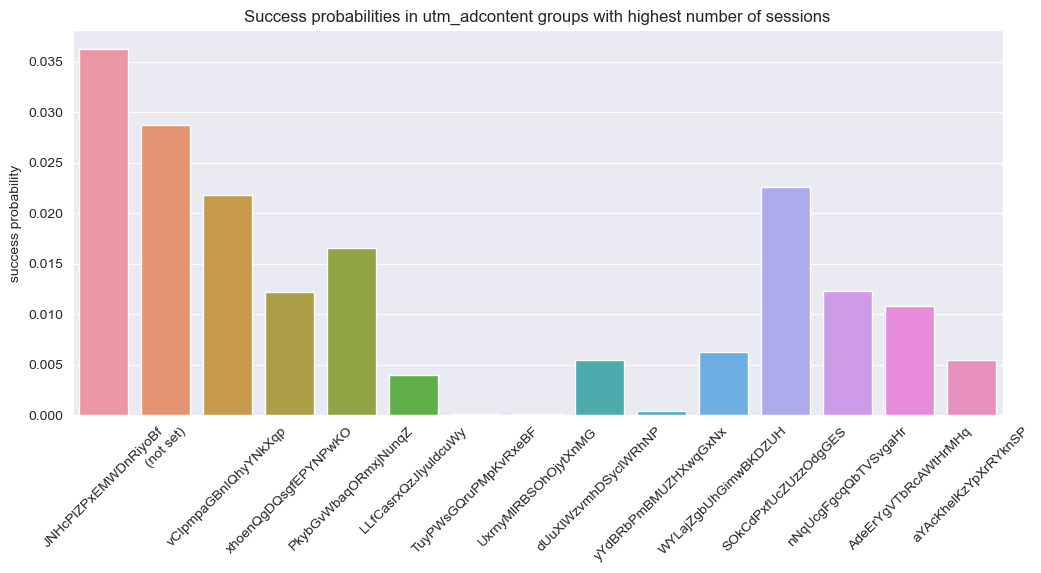

In [399]:
barplot_max_total_sessions(df_new, 'utm_adcontent', 15)

Most of the values in utm columns have minimum deviations from the mean target action probability. The most valuable information
to identify certain success has been found in minor groups. 

Considering very low general probability of target action and limited abilities of using small groups for model training

the SUGGESTED APPROACH is:

to transform all utm categorical values into target action probability coefficient.
Coefficients are to be defined for each major region individually.
Also we shall sort values into major marketing campaigns for probability coefficient calculation to get more information on the marketing campaigns
with the biggest number of successful sessions (over 1000 successful sessions). All the other marketing campaigns with less successful sessions will be united into one general category.

To avoid splitting dataframe into too many groups with very few sessions in each group (that would eventually lead to overfitting)
we will only use limited number of major marketing campaigns and regions with no less than 7000 sessions.
Regions column will be created at the next step.

Also the minimum number of sessions for group probability calculation will be set to 300 (exact number selected after testing the following values:
30, 50, 100, 150, 200, 300, 500).

NB: at columns transformation stage high collinearity between utm_source and utm_medium was found (pearson over 0.78).
Also as it can be seen from the list of unique values above, utm_medium column values are split into groups that are significant
for ads conversion rate and spending calculations but they are no different from the client's perspective.
The groups are cpm, cpc, cpv etc. These are all paid ads with different payment strategies that do not affect visitors on any level.
For these two reasons utm_medium column will be dropped.

#### c) geographic features (split into regions)

In [519]:
# Import global cities dataset with cities region and country affiliation

df_cities = pd.read_csv(r'C:\Users\10\Documents\WWW\Final_folder\worldcities.csv')
df_cities = df_cities[['city_ascii', 'admin_name', 'country']]

# Transform data to dictionary

df_cities.set_index('city_ascii', inplace=True)
cities_regions = df_cities.to_dict()

cities_regions

{'admin_name': {'Tokyo': 'Tōkyō',
  'Jakarta': 'Jakarta',
  'Delhi': 'California',
  'Guangzhou': 'Guangdong',
  'Mumbai': 'Mahārāshtra',
  'Manila': 'Manila',
  'Shanghai': 'Shanghai',
  'Sao Paulo': 'São Paulo',
  'Seoul': 'Seoul',
  'Mexico City': 'Ciudad de México',
  'Cairo': 'Georgia',
  'New York': 'New York',
  'Dhaka': 'Bihār',
  'Beijing': 'Beijing',
  'Kolkata': 'West Bengal',
  'Bangkok': 'Krung Thep Maha Nakhon',
  'Shenzhen': 'Guangdong',
  'Moscow': "'Moskovskaya Oblast’'",
  'Buenos Aires': 'Pernambuco',
  'Lagos': 'Anatolikí Makedonía kai Thráki',
  'Istanbul': 'İstanbul',
  'Karachi': 'Sindh',
  'Bangalore': 'Karnātaka',
  'Ho Chi Minh City': 'Hồ Chí Minh',
  'Osaka': 'Ōsaka',
  'Chengdu': 'Sichuan',
  'Tehran': 'Tehrān',
  'Kinshasa': 'Kinshasa',
  'Rio de Janeiro': 'Rio de Janeiro',
  'Chennai': 'Tamil Nādu',
  "Xi'an": 'Shaanxi',
  'Lahore': 'Punjab',
  'Chongqing': 'Chongqing',
  'Los Angeles': 'Biobío',
  'Baoding': 'Hebei',
  'London': 'Ohio',
  'Paris': 'Illino

In [479]:
cities_regions['admin_name'].get('Moscow')

"'Moskovskaya Oblast’'"

In [520]:
# Create new column for region (in Russia only)

df_new['region'] = df_new.geo_city.apply(lambda x: '' if cities_regions['country'].get(
        x, 'other') != 'Russia' else cities_regions['admin_name'].get(x, ''))

In [521]:
# Update region names:
# for foreign countries use country as region name
# for Russia use region (admin_name) added above

df_new['geo_country'] = df_new['geo_country'].apply(lambda x: '' if x == 'Russia' else x)
df_new['region'] = df_new['geo_country'] + df_new['region']
df_new[['geo_city', 'geo_country', 'region']].head(5)

,geo_city,geo_country,region
0,Zlatoust,,Chelyabinskaya Oblast’
1,Moscow,,'Moskovskaya Oblast’'
2,Krasnoyarsk,,Krasnoyarskiy Kray
3,Moscow,,'Moskovskaya Oblast’'
4,Moscow,,'Moskovskaya Oblast’'


In [522]:
# Single out major cities with most successful sessions as separate regions

df_positive = df_new[df_new.target == 1]
major_cities = list(df_positive.geo_city.value_counts()[df_positive.geo_city.value_counts() > 1000].index)
if '(not set)' in major_cities:
    major_cities.remove('(not set)')
for city in major_cities:
    df_new.loc[df_new.geo_city == city, 'region'] = city

df_new[df_new.geo_city == 'Moscow'].head(3)

,visit_dt,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,target,date,prev_visit,prev_session_duration,mean_result,mean_actions,days_after_last_visit,ad_start_tmp,days_since_ad_st,region
1,2021-11-14 08:21:30,905544597018549464.1636867290.1636867290,210838531.1636867288,1.0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,...,0,738009,0,0.000000e+00,0.0,0.0,57.609902,2021-10-04 17:00:00,41.0,Moscow
3,2021-05-29 05:00:00,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1.0,kjsLglQLzykiRbcDiGcD,cpc,(not set),NOBKLgtuvqYWkXQHeYWM,(not set),mobile,...,0,737844,0,0.000000e+00,0.0,0.0,57.609902,2021-05-28 19:00:00,0.0,Moscow
4,2021-05-29 05:00:00,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2.0,kjsLglQLzykiRbcDiGcD,cpc,(not set),(not set),(not set),mobile,...,0,737844,2021-05-29 05:00:00,1.082972e+06,0.0,3.0,0.000000,2021-05-21 18:00:00,7.0,Moscow


In [523]:
# Make a list of small regions with number of sessions below 7000

small_regions = []
for region in df_new.region.unique():
    if len(df_new[df_new.region == region]) < 10000:
        small_regions.append(region)
print(small_regions)

['Yaroslavskaya Oblast’', 'Vladimirskaya Oblast’', 'Astrakhanskaya Oblast’', 'United States', 'Ul’yanovskaya Oblast’', 'Mariy-El', 'Sakhalinskaya Oblast’', 'Lipetskaya Oblast’', 'Tyva', 'Ryazanskaya Oblast’', 'Tyumenskaya Oblast’', 'Omskaya Oblast’', 'Kemerovskaya Oblast’', 'Saratovskaya Oblast’', 'Orenburgskaya Oblast’', 'Khanty-Mansiyskiy Avtonomnyy Okrug-Yugra', 'Ukraine', 'Volgogradskaya Oblast’', 'Tatarstan', 'Khabarovskiy Kray', 'Kaluzhskaya Oblast’', 'Leningradskaya Oblast’', 'Altayskiy Kray', 'Italy', 'Tambovskaya Oblast’', 'Belarus', 'Tverskaya Oblast’', 'UkraineCrimea', 'Kostromskaya Oblast’', '(not set)', 'Kurskaya Oblast’', 'Stavropol’skiy Kray', 'Udmurtiya', 'Karachayevo-Cherkesiya', 'Sweden', 'Kabardino-Balkariya', 'Belgorodskaya Oblast’', 'Permskiy Kray', 'Arkhangel’skaya Oblast’', 'Komi', 'Australia', 'Tomskaya Oblast’', 'Kazakhstan', 'Estonia', 'Azerbaijan', 'Khakasiya', 'Smolenskaya Oblast’', 'Vologodskaya Oblast’', 'Brazil', 'Montenegro', 'Kareliya', 'Orlovskaya Obla

In [524]:
# Create federal districts dictionary to merge small regions into bigger entities

federal_districts = {}

for region in list(df_new[df_new.geo_country != 'Russia']['geo_country'].unique()):
    federal_districts[region] = 'foreign region'
    
federal_districts[''] = 'Russia'

for region in ['Chechnya', 'Stavropol’skiy Kray', 'Karachayevo-Cherkesiya',
               'Kabardino-Balkariya', 'Ingushetiya', 'Dagestan', 'North Ossetia']:
    federal_districts[region] = 'North Caucasian'

for region in ['Moskovskaya Oblast’', 'Yaroslavskaya Oblast’', 'Tul’skaya Oblast’',
               'Lipetskaya Oblast’', 'Ryazanskaya Oblast’', 'Kaluzhskaya Oblast’',
               'Tambovskaya Oblast’', 'Tverskaya Oblast’', 'Kostromskaya Oblast’',
               'Kurskaya Oblast’', 'Voronezhskaya Oblast’', 'Belgorodskaya Oblast’',
               'Smolenskaya Oblast’', 'Orlovskaya Oblast’', 'Bryanskaya Oblast’',
               'Vladimirskaya Oblast’', 'Ivanovskaya Oblast’']:
    federal_districts[region] = 'Central'

for region in ['Leningradskaya Oblast’', 'Arkhangel’skaya Oblast’', 'Komi',
               'Vologodskaya Oblast’', 'Kareliya', 'Novgorodskaya Oblast’',
               'Kaliningradskaya Oblast’', 'Pskovskaya Oblast’', 'Murmanskaya Oblast’']:
    federal_districts[region] = 'Northwestern'

for region in ['Tatarstan', 'Ul’yanovskaya Oblast’', 'Samarskaya Oblast’',
               'Mariy-El', 'Nizhegorodskaya Oblast’', 'Bashkortostan',
               'Saratovskaya Oblast’', 'Orenburgskaya Oblast’', 'Kirovskaya Oblast’',
               'Udmurtiya', 'Permskiy Kray', 'Chuvashiya', 'Penzenskaya Oblast’',
               'Mordoviya']:
    federal_districts[region] = 'Volga'

for region in ['Krasnodarskiy Kray', 'Astrakhanskaya Oblast’', 'Rostovskaya Oblast’',
               'Rostovskaya Oblast’', 'Volgogradskaya Oblast’', 'UkraineCrimea',
               'Adygeya', 'Kalmykiya']:
    federal_districts[region] = 'Southern'

for region in ['Chelyabinskaya Oblast’', 'Sverdlovskaya Oblast’', 'Tyumenskaya Oblast’',
                         'Khanty-Mansiyskiy Avtonomnyy Okrug-Yugra', 'Yamalo-Nenetskiy Avtonomnyy Okrug',
                         'Kurganskaya Oblast’']:
    federal_districts[region] = 'Ural'

for region in ['Krasnoyarskiy Kray', 'Tyva', 'Omskaya Oblast’', 'Kemerovskaya Oblast’',
               'Novosibirskaya Oblast’', 'Altayskiy Kray', 'Tomskaya Oblast’',
               'Irkutskaya Oblast’', 'Khakasiya', 'Altay']:
    federal_districts[region] = 'Siberian'

for region in ['Primorskiy Kray', 'Khabarovskiy Kray', 'Zabaykal’skiy Kray',
               'Amurskaya Oblast’', 'Sakha (Yakutiya)', 'Sakhalinskaya Oblast’',
               'Buryatiya', 'Kamchatskiy Kray', 'Magadanskaya Oblast’',
               'Yevreyskaya Avtonomnaya Oblast’', 'Chukotskiy Avtonomnyy Okrug']:
    federal_districts[region] = 'Far Eastern'

federal_districts

{'': 'Russia',
 'United States': 'foreign region',
 'Ukraine': 'foreign region',
 'Italy': 'foreign region',
 'Belarus': 'foreign region',
 '(not set)': 'foreign region',
 'Sweden': 'foreign region',
 'Australia': 'foreign region',
 'Kazakhstan': 'foreign region',
 'Estonia': 'foreign region',
 'Azerbaijan': 'foreign region',
 'Brazil': 'foreign region',
 'Montenegro': 'foreign region',
 'Bulgaria': 'foreign region',
 'Georgia': 'foreign region',
 'Uzbekistan': 'foreign region',
 'Tajikistan': 'foreign region',
 'Ireland': 'foreign region',
 'Cyprus': 'foreign region',
 'United Arab Emirates': 'foreign region',
 'Germany': 'foreign region',
 'United Kingdom': 'foreign region',
 'Netherlands': 'foreign region',
 'Spain': 'foreign region',
 'Finland': 'foreign region',
 'Turkey': 'foreign region',
 'Poland': 'foreign region',
 'Kyrgyzstan': 'foreign region',
 'India': 'foreign region',
 'Bangladesh': 'foreign region',
 'Latvia': 'foreign region',
 'Seychelles': 'foreign region',
 'Norway

In [525]:
# Apply dictionary to small regions

df_new.region = df_new.region.apply(lambda x: x if x not in small_regions else federal_districts.get(x, 'Russia'))
df_new.region = df_new.region.apply(lambda x: x if x else 'Russia')

In [526]:
# View new regions size

for region in df_new.region.unique():
    print(region, len(df_new[df_new.region == region]))

Chelyabinskaya Oblast’ 16338
Moscow 750873
Krasnoyarskiy Kray 16638
Saint Petersburg 278399
Krasnodarskiy Kray 12366
Central 47789
Moskovskaya Oblast’ 101274
Russia 74915
Primorskiy Kray 11843
Southern 10072
foreign region 46337
Kazan 27689
Volga 33307
Tul’skaya Oblast’ 14825
Sverdlovskaya Oblast’ 35621
Rostovskaya Oblast’ 14359
Samarskaya Oblast’ 25292
Far Eastern 11191
Krasnodar 30260
Siberian 14879
Ural 14114
Nizhegorodskaya Oblast’ 21774
Bashkortostan 23321
Chechnya 12014
Novosibirskaya Oblast’ 20310
Northwestern 24600
North Caucasian 15282
Voronezhskaya Oblast’ 12839
Irkutskaya Oblast’ 13669


|    | region                |   successful_sessions |   total_sessions |   success_percent |
|---:|:----------------------|----------------------:|-----------------:|------------------:|
| 18 | Russia                |                  1600 |            74915 |         0.0213575 |
| 16 | Primorskiy Kray       |                   254 |            11843 |         0.0214473 |
| 21 | Siberian              |                   325 |            14879 |         0.0218429 |
| 27 | Voronezhskaya Oblast’ |                   287 |            12839 |         0.0223538 |
| 28 | foreign region        |                  1046 |            46337 |         0.0225738 |
| 14 | Northwestern          |                   590 |            24600 |         0.0239837 |
| 25 | Ural                  |                   339 |            14114 |         0.0240187 |
| 13 | North Caucasian       |                   667 |            15282 |         0.0436461 |
|  6 | Kazan                 |                  1139 |      

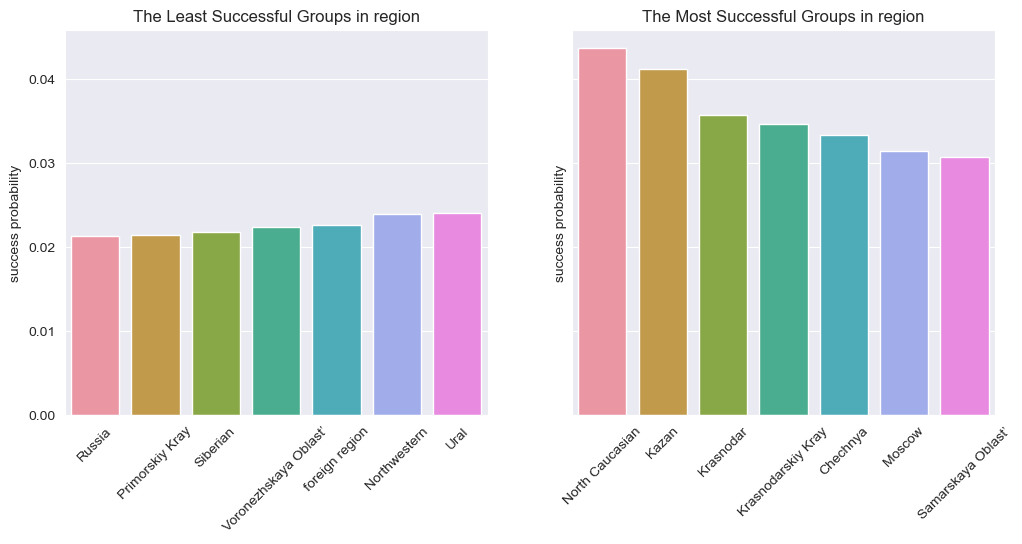

In [527]:
barplot_minmax_success(df_new, 'region', 7, 7)

|     | utm_campaign     |   target |   session_id |   success_percent |
|----:|:-----------------|---------:|-------------:|------------------:|
| 214 | Moscow_emlBaV    |      107 |          598 |         0.17893   |
|  63 | Moscow_KCcrgo    |       18 |          116 |         0.155172  |
| 348 | Moscow_yEzOkU    |        8 |           56 |         0.142857  |
| 344 | Moscow_xGRbRu    |       14 |          114 |         0.122807  |
|  51 | Moscow_IWLzPA    |       30 |          249 |         0.120482  |
| 259 | Moscow_kwdmEl    |       13 |          121 |         0.107438  |
| 140 | Moscow_TzXEvS    |       10 |          100 |         0.1       |
| 142 | Krasnodar_sbJRYg |        8 |          105 |         0.0761905 |
| 103 | Krasnodar_hkvDVx |        4 |           61 |         0.0655738 |
|  82 | Krasnodar_YCKgTz |        9 |          151 |         0.0596026 |
| 126 | Krasnodar_nSReTm |        6 |          112 |         0.0535714 |
|  30 | Krasnodar_LTuZkd |      328 |         6806 

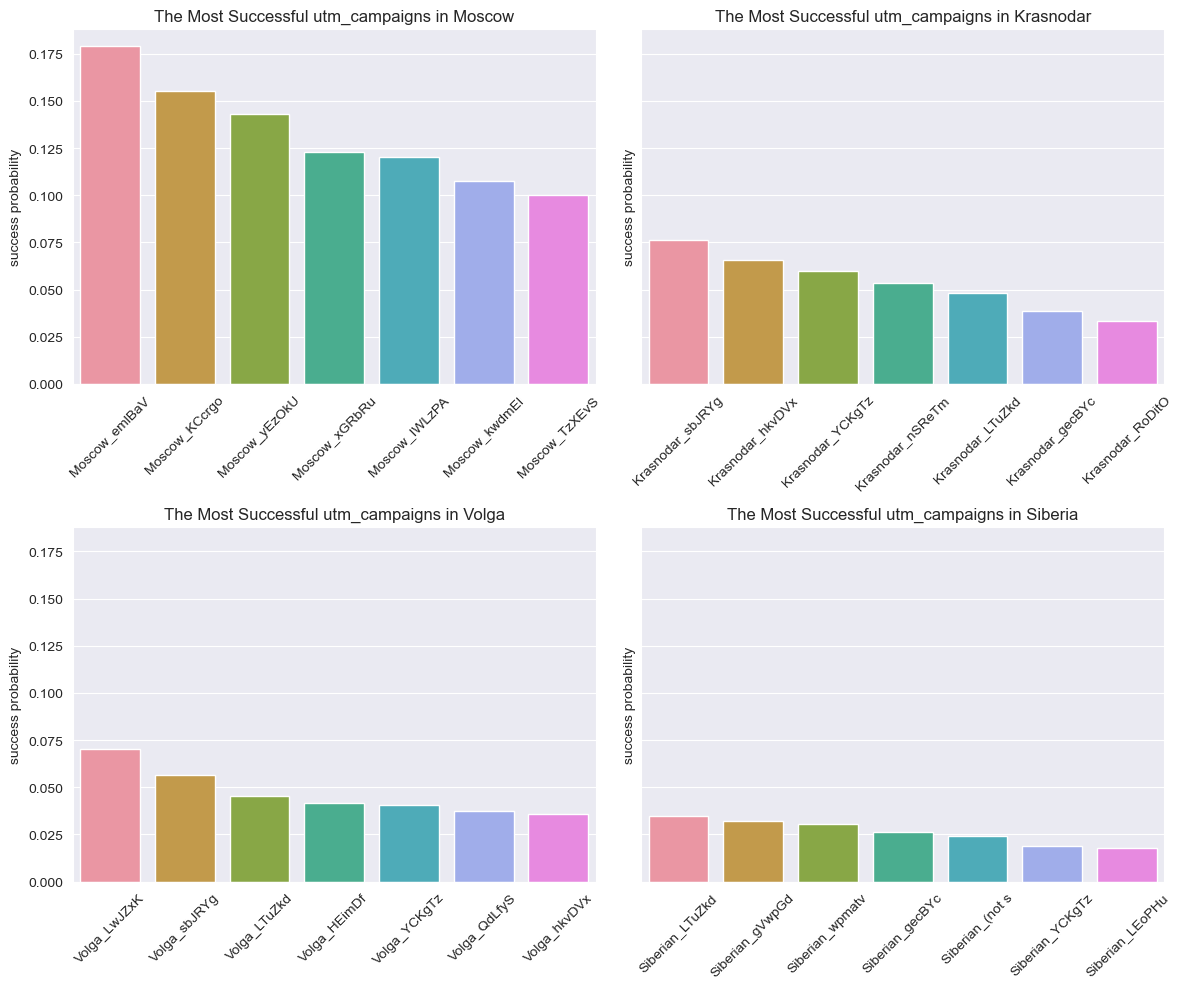

In [528]:
# Plot regional differences by utm_campaign

df_msk = df_new[df_new.region == 'Moscow'][['utm_campaign', 'target', 'session_id']].groupby(
    'utm_campaign').agg({'target': 'sum', 'session_id': 'count'}).reset_index()
df_msk['success_percent'] = df_msk['target']/df_msk['session_id']
df_msk = df_msk[df_msk.session_id > 50]
df_msk.utm_campaign = df_msk.utm_campaign.apply(lambda x: 'Moscow_' + x[:6])
df_krnd = df_new[df_new.region == 'Krasnodar'][['utm_campaign', 'target', 'session_id']].groupby(
    'utm_campaign').agg({'target': 'sum', 'session_id': 'count'}).reset_index()
df_krnd['success_percent'] = df_krnd['target']/df_krnd['session_id']
df_krnd = df_krnd[df_krnd.session_id > 50]
df_krnd.utm_campaign = df_krnd.utm_campaign.apply(lambda x: 'Krasnodar_' + x[:6])
df_vlg = df_new[df_new.region == 'Volga'][['utm_campaign', 'target', 'session_id']].groupby(
    'utm_campaign').agg({'target': 'sum', 'session_id': 'count'}).reset_index()
df_vlg['success_percent'] = df_vlg['target']/df_vlg['session_id']
df_vlg = df_vlg[df_vlg.session_id > 50]
df_vlg.utm_campaign = df_vlg.utm_campaign.apply(lambda x: 'Volga_' + x[:6])
df_sib = df_new[df_new.region == 'Siberian'][['utm_campaign', 'target', 'session_id']].groupby(
    'utm_campaign').agg({'target': 'sum', 'session_id': 'count'}).reset_index()
df_sib['success_percent'] = df_sib['target']/df_sib['session_id']
df_sib = df_sib[df_sib.session_id > 50]
df_sib.utm_campaign = df_sib.utm_campaign.apply(lambda x: 'Siberian_' + x[:6])
       
# Plot distribution of success percentage
plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(12, 10))
plot_1 = df_msk.nlargest(7, 'success_percent')
plot_2 = df_krnd.nlargest(7, 'success_percent')
plot_3 = df_vlg.nlargest(7, 'success_percent')
plot_4 = df_sib.nlargest(7, 'success_percent')
print(pd.concat([plot_1, plot_2, plot_3, plot_4], axis=0).to_markdown())

plt.subplot(221)
sns.barplot(plot_1, x='utm_campaign', y='success_percent')
plt.xticks(rotation=45)
plt.title('The Most Successful utm_campaigns in Moscow')
plt.ylabel('success probability')
plt.xlabel('')

plt.subplot(222)
sns.barplot(plot_2, x='utm_campaign', y='success_percent')
plt.xticks(rotation=45)
plt.title('The Most Successful utm_campaigns in Krasnodar')
plt.ylabel('success probability')
plt.xlabel('')

plt.subplot(223)
sns.barplot(plot_3, x='utm_campaign', y='success_percent')
plt.xticks(rotation=45)
plt.title('The Most Successful utm_campaigns in Volga')
plt.ylabel('success probability')
plt.xlabel('')

plt.subplot(224)
sns.barplot(plot_4, x='utm_campaign', y='success_percent')
plt.xticks(rotation=45)
plt.title('The Most Successful utm_campaigns in Siberia')
plt.ylabel('success probability')
plt.xlabel('')
plt.tight_layout();

#### d) device_category, device_brand, device_screen_resolution

|    | device_category   |   successful_sessions |   total_sessions |   success_percent |
|---:|:------------------|----------------------:|-----------------:|------------------:|
|  1 | mobile            |                 38377 |          1368651 |         0.02804   |
|  0 | desktop           |                 11510 |           346843 |         0.033185  |
|  2 | tablet            |                   422 |            16696 |         0.0252755 |


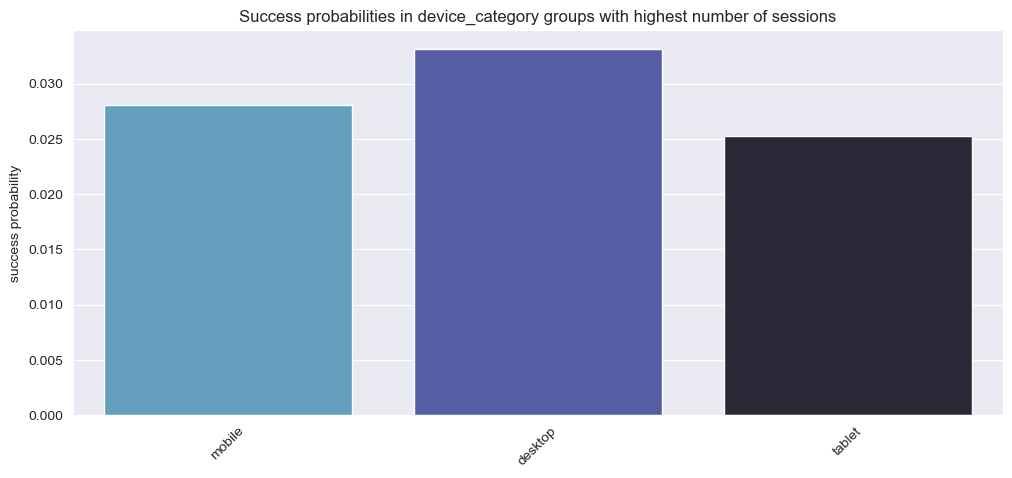

In [411]:
barplot_max_total_sessions(df_new, 'device_category', 5)

|     | device_brand   |   successful_sessions |   total_sessions |   success_percent |
|----:|:---------------|----------------------:|-----------------:|------------------:|
|  10 | Apple          |                 15992 |           542297 |         0.0294894 |
|   0 | (not set)      |                 10444 |           324769 |         0.0321582 |
| 145 | Samsung        |                 10053 |           311636 |         0.0322588 |
| 191 | Xiaomi         |                  6592 |           269242 |         0.0244836 |
|  76 | Huawei         |                  4518 |           173823 |         0.025992  |
| 144 | Realme         |                   421 |            17925 |         0.0234868 |
| 127 | OPPO           |                   396 |            12775 |         0.030998  |
| 178 | Vivo           |                   322 |            11026 |         0.0292037 |
| 129 | OnePlus        |                   157 |             9321 |         0.0168437 |
|  14 | Asus           |        

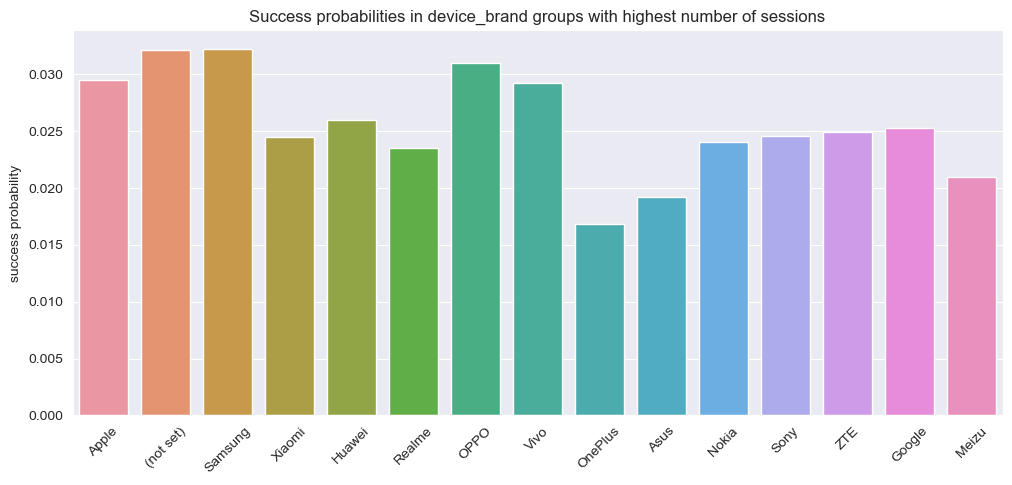

In [412]:
barplot_max_total_sessions(df_new, 'device_brand', 15)

|      | device_screen_resolution   |   successful_sessions |   total_sessions |   success_percent |
|-----:|:---------------------------|----------------------:|-----------------:|------------------:|
| 3359 | 414x896                    |                  4397 |           155137 |         0.0283427 |
| 1181 | 1920x1080                  |                  3577 |           119209 |         0.0300061 |
| 2713 | 393x851                    |                  2932 |           107968 |         0.0271562 |
| 2291 | 375x812                    |                  3168 |           106960 |         0.0296185 |
| 2027 | 360x780                    |                  2344 |            86713 |         0.0270317 |
| 2242 | 375x667                    |                  2465 |            86130 |         0.0286195 |
| 2047 | 360x800                    |                  2276 |            75163 |         0.0302809 |
| 3213 | 412x915                    |                  2667 |            70483 |         0.

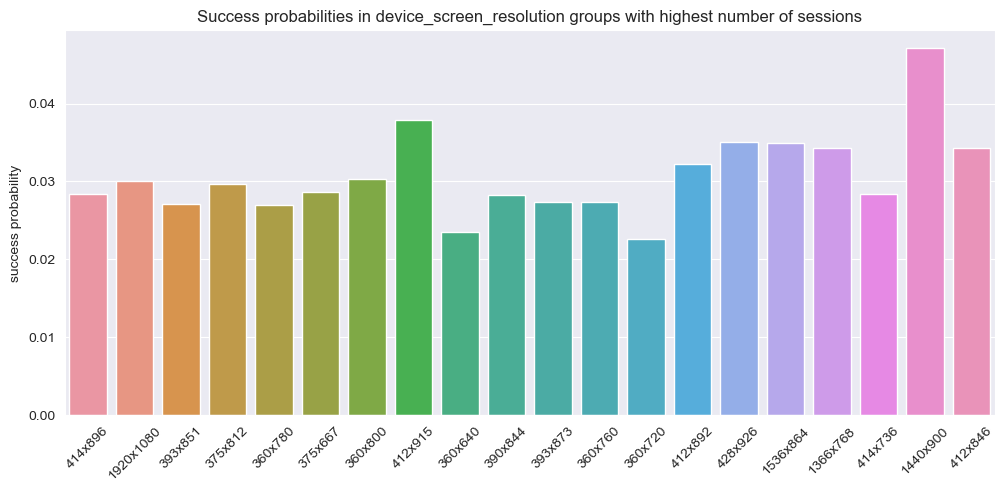

In [413]:
barplot_max_total_sessions(df_new, 'device_screen_resolution', 20)

Device brand and model could be used as a predictor for indirect user profile understanding (e.g. Apple fans, edge technology fans, old schoolers. expensive device owners etc.) Unfrotunately device model has too many missing entries.
However this can be fixed with mixed device brand and device screen resolution that seems to be quite unique for different models and brands.
Also this allows us to disregard device category as it would obviously match the screen resolution.

In [529]:
# Join brand with device_screen_resolution

df_new['device_screen_resolution'] = df_new.device_screen_resolution + df_new.device_brand

|      | device_screen_resolution   |   successful_sessions |   total_sessions |   success_percent |
|-----:|:---------------------------|----------------------:|-----------------:|------------------:|
|   57 | 1024x640(not set)          |                     0 |              106 |         0         |
|  147 | 1080x1920(not set)         |                     0 |               80 |         0         |
|  545 | 1280x960(not set)          |                     0 |              457 |         0         |
|  661 | 1364x768(not set)          |                     0 |               53 |         0         |
|  714 | 1376x774(not set)          |                     0 |               76 |         0         |
|  807 | 1450x816(not set)          |                     0 |              142 |         0         |
|  924 | 1536x824(not set)          |                     0 |              305 |         0         |
|  930 | 1536x865(not set)          |                     0 |               71 |         0 

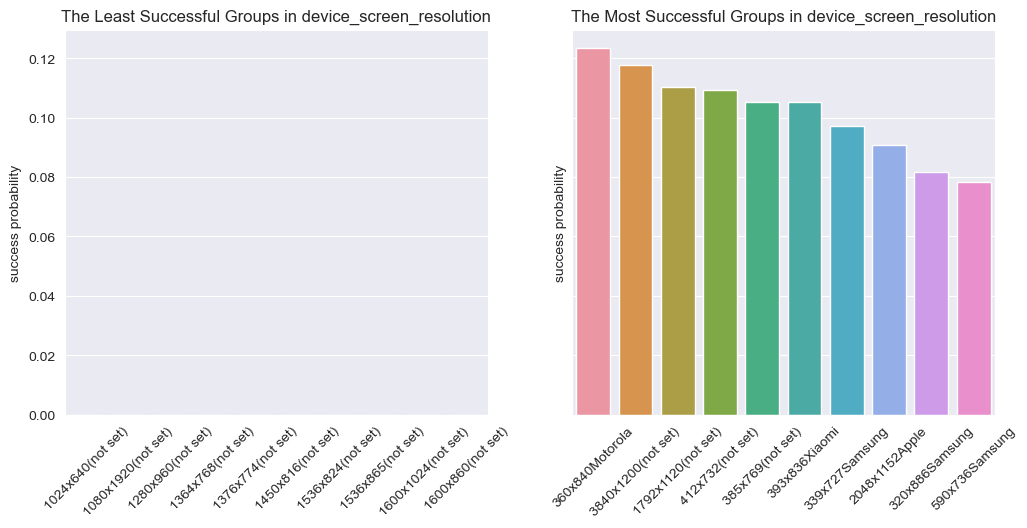

In [415]:
barplot_minmax_success(df_new, 'device_screen_resolution', 10, 10)

#### f) geo_country, geo_city

Geo_city column seems to be the most valueable feature in the dataset.
However here we are facing the same problem as with utm features. The most and least successful cities have few sessions and might simply be lost at undersampling stage.

The approach will be the same and city names will be transformed into numeric success probabilities. In this way smaller cities with approximately the same success ratio will naturally merge and increase their visibility for the model fitting stage. So they will depend less on the number of samples that will make it into the undesampled dataframe.

Geo_country will be dropped in favor of geo_city and region.

|     | geo_country    |   successful_sessions |   total_sessions |   success_percent |
|----:|:---------------|----------------------:|-----------------:|------------------:|
|   0 |                |                 49151 |          1682347 |       0.0292157   |
| 148 | Ukraine        |                   199 |             8455 |       0.0235364   |
| 151 | United States  |                    64 |             8141 |       0.00786144  |
|  17 | Belarus        |                    59 |             3432 |       0.0171911   |
|  72 | Kazakhstan     |                    54 |             2109 |       0.0256046   |
|  51 | Germany        |                    78 |             2085 |       0.0374101   |
|  67 | Ireland        |                     1 |             1989 |       0.000502765 |
| 145 | Turkey         |                    48 |             1787 |       0.0268607   |
| 136 | Sweden         |                    26 |             1731 |       0.0150202   |
|  98 | Netherlands    |        

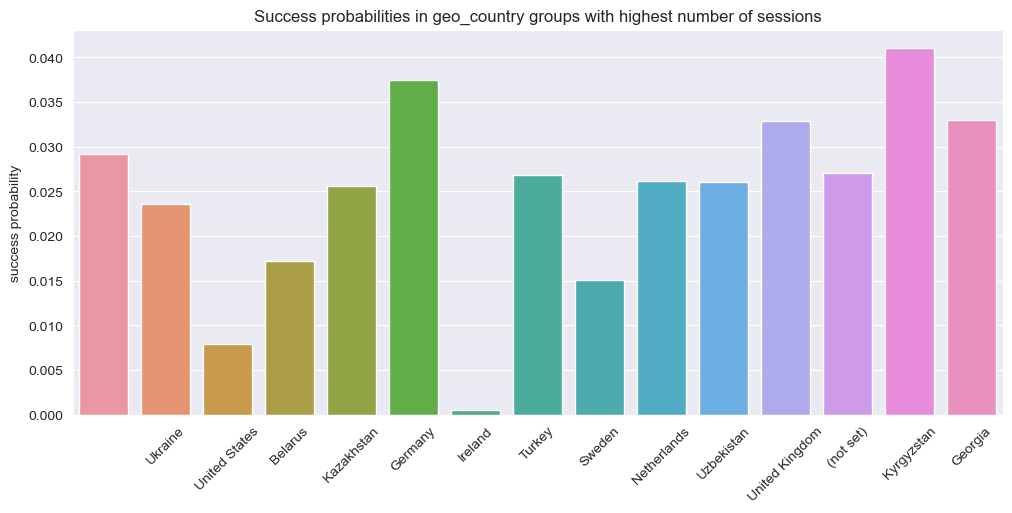

In [416]:
barplot_max_total_sessions(df_new, 'geo_country', 15)

|      | geo_city        |   successful_sessions |   total_sessions |   success_percent |
|-----:|:----------------|----------------------:|-----------------:|------------------:|
|    7 | 24130           |                     0 |               51 |         0         |
|   60 | Aksay           |                     0 |               90 |         0         |
|   84 | Altoona         |                     0 |              788 |         0         |
|  146 | Ashburn         |                     0 |             1269 |         0         |
|  284 | Birobidzhan     |                     0 |               68 |         0         |
|  382 | Cairo           |                     0 |               71 |         0         |
|  531 | Dnipro          |                     0 |               91 |         0         |
|  556 | Dublin          |                     0 |             1975 |         0         |
|  647 | Forest City     |                     0 |             1248 |         0         |
|  651 | F

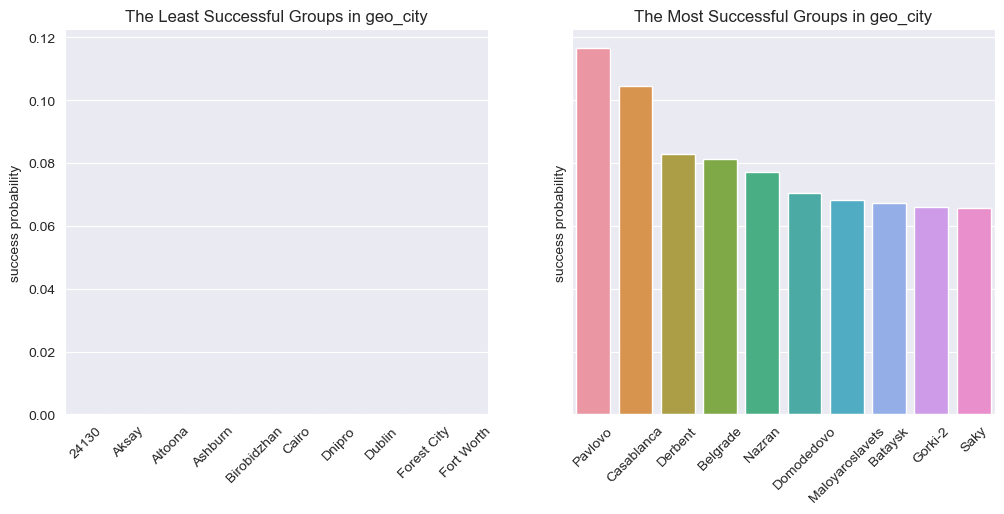

In [417]:
barplot_minmax_success(df_new, 'geo_city', 10, 10)

## 3.5 Data Transformation

### 3.5.1 Split dataframe into train and test before calculating success probaibilities to avoid data leak

In [613]:
# Split data for training and testing

df_new_target = df_new.target

x_train, x_test, y_train, y_test = train_test_split(
    df_new, df_new_target, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [419]:
x_train

,visit_dt,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,target,date,prev_visit,prev_session_duration,mean_result,mean_actions,days_after_last_visit,ad_start_tmp,days_since_ad_st,region
603145,2021-12-07 12:26:49,364826206072154358.1638869209.1638869209,84942720.1638869238,1.000000,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,...,0,738032,0,0.000000e+00,0.0,0.0,57.609902,2021-05-19 10:00:00,202.0,Saint Petersburg
87937,2021-08-04 19:00:00,1174736169117336225.1628095137.1628095171,273514578.1628095137,1.000000,bByPQxmDaMXgpHeypKSM,referral,HEimDfYZIzuQXDZAAcEW,XSkXBCPfnJjvxbfeewtd,(not set),desktop,...,0,737909,0,0.000000e+00,0.0,0.0,57.609902,2021-07-13 09:00:00,22.0,Krasnodarskiy Kray
526373,2021-12-10 11:09:38,3278064267675503424.1639123778.1639123778,763233813.1639123776,1.000000,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,0,738035,0,0.000000e+00,0.0,0.0,57.609902,2021-11-18 16:07:20,22.0,Bashkortostan
925186,2021-07-13 00:00:00,519039905925214571.1626124652.1626124652,120848395.1626124651,1.000000,kjsLglQLzykiRbcDiGcD,cpc,DnEUulZAecfGPvdtZBYS,JNHcPlZPxEMWDnRiyoBf,(not set),mobile,...,0,737888,0,0.000000e+00,0.0,0.0,57.609902,2021-05-19 10:00:00,55.0,Moscow
928177,2021-10-24 09:02:40,5204743754358257408.1635055360.1635055360,1211823838.1635055360,1.000000,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,...,0,737989,0,0.000000e+00,0.0,0.0,57.609902,2021-05-19 10:00:00,158.0,Saint Petersburg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292824,2021-08-27 19:00:00,2163019641556374047.1630081567.1630081567,503617255.1630081567,1.000000,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,dUuXlWzvmhDSyclWRhNP,(not set),mobile,...,0,737932,0,0.000000e+00,0.0,0.0,57.609902,2021-07-02 22:00:00,56.0,Saint Petersburg
910943,2021-08-24 00:00:00,512271698895310199.1629752696.1629752696,119272549.1629752695,1.000000,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,(not set),tablet,...,0,737929,0,0.000000e+00,0.0,0.0,57.609902,2021-06-22 09:00:00,63.0,Moscow
21396,2021-08-09 19:00:00,9157313345526783500.1628528145.1628528145,2132103160.1628528140,2.000000,kjsLglQLzykiRbcDiGcD,cpc,(not set),(not set),(not set),mobile,...,1,737914,2021-08-09 19:00:00,1.082972e+06,0.0,2.0,0.000000,2021-05-21 18:00:00,80.0,Moscow
520927,2021-08-29 14:00:00,325284924653248589.1630237562.1630237562,75736298.1623138381,37.555634,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,(not set),desktop,...,0,737934,2021-08-29 13:00:00,1.082972e+06,0.0,5.6,0.041667,2021-05-19 10:00:00,102.0,Rostovskaya Oblast’


### 3.5.2 Transform utm and device features into success coefficients

In [614]:
# Transform column values into success coefficients

coef_cols = ['utm_campaign', 'utm_source', 'utm_adcontent', 'utm_keyword']

# Add major column marker to utm columns

major_campaigns = list(x_train[x_train.target == 1].utm_source.value_counts().head(4).index)
dependency_cols = ['utm_source', 'utm_keyword', 'utm_adcontent']
x_train['major_campaign'] = x_train.utm_campaign.apply(lambda x: x[:5] if x in major_campaigns else '')
x_test['major_campaign'] = x_test.utm_campaign.apply(lambda x: x[:5] if x in major_campaigns else '')

for column in dependency_cols:
    x_train[column] = x_train['major_campaign'] + x_train[column]
    x_test[column] = x_test['major_campaign'] + x_test[column]

# Calculate success probabilities 

for column in coef_cols:
    tmp_success = x_train[['region', column, 'session_id', 'target']].groupby(['region', column]).agg(
                {'session_id': 'count', 'target': 'sum'}).reset_index()
    tmp_success[column + '_success'] = tmp_success['target'] / tmp_success['session_id']
    fill_value = tmp_success[(tmp_success.session_id < 150) & (
                tmp_success[column + '_success'] < 0.06)][column + '_success'].mean()
    tmp_success.loc[tmp_success.session_id < 30, column + '_success'] = fill_value
    tmp_success.loc[
            (tmp_success.session_id < 150) & (tmp_success[column + '_success'] < 0.06),
            column + '_success'] = fill_value
    tmp_success = tmp_success[['region', column, column + '_success']].drop_duplicates(
            subset=['region', column])
    x_train = pd.merge(x_train, tmp_success, how='left', on=['region', column])
    x_test = pd.merge(x_test, tmp_success, how='left', on=['region', column])
    x_test[column + '_success'].fillna(fill_value, inplace=True)

The logic behind minimum session number selection for device_screen_resolution and geo_city below is that supposedly geo_city actually does have major influence over target action probability so we must keep as much information as reasonably possible.
At the same time device model derived from screen resolution and brand has very vague connection with success probability so we wouldn't want to go into too many details here.

In [615]:
# Calculate success probabilities for device screen resolution and geo_city
# Use 30 and 50 as the minimum number of sessions for probability calcultaion

city_success = x_train[['geo_city', 'session_id', 'target']].groupby('geo_city').agg(
        {'session_id': 'count', 'target': 'sum'}).reset_index()
city_success['geo_city_success'] = round(city_success['target'] /
                                             city_success['session_id'], 3)
city_success = city_success[city_success.session_id > 30]
city_success.drop(columns=['session_id', 'target'], inplace=True)
x_train = pd.merge(x_train, city_success, how='left', on=['geo_city'])
x_train['geo_city_success'] = x_train['geo_city_success'].fillna(x_train.geo_city_success.median())
x_test = pd.merge(x_test, city_success, how='left', on=['geo_city'])
x_test['geo_city_success'] = x_test['geo_city_success'].fillna(x_train.geo_city_success.median())

resolution_success = x_train[['device_screen_resolution', 'session_id',
                             'target']].groupby('device_screen_resolution').agg(
        {'session_id': 'count', 'target': 'sum'}).reset_index()
resolution_success['device_screen_resolution_success'] = round(
        resolution_success['target'] / resolution_success['session_id'], 3)
resolution_success = resolution_success[resolution_success.session_id > 50]
resolution_success.drop(columns=['session_id', 'target'], inplace=True)
x_train = pd.merge(x_train, resolution_success, how='left', on=['device_screen_resolution'])
x_train['device_screen_resolution_success'] = x_train['device_screen_resolution_success'].fillna(
            x_train.device_screen_resolution_success.median())
x_test = pd.merge(x_test, resolution_success, how='left', on=['device_screen_resolution'])
x_test['device_screen_resolution_success'] = x_test['device_screen_resolution_success'].fillna(
            x_train.device_screen_resolution_success.median())

### 3.5.3 Drop columns after feature enegineering

In [616]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212533 entries, 0 to 1212532
Data columns (total 35 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   visit_dt                          1212533 non-null  datetime64[ns]
 1   session_id                        1212533 non-null  object        
 2   client_id                         1212533 non-null  object        
 3   visit_number                      1212533 non-null  float64       
 4   utm_source                        1212533 non-null  object        
 5   utm_medium                        1212533 non-null  object        
 6   utm_campaign                      1212533 non-null  object        
 7   utm_adcontent                     1212533 non-null  object        
 8   utm_keyword                       1212533 non-null  object        
 9   device_category                   1212533 non-null  object        
 10  device_brand      

In [617]:
cols_to_drop = [
    'session_id',
    'client_id',
    'device_brand',
    'device_category',
    'device_browser',
    'event_action',
    'result',
    'session_duration',
    'visit_dt',
    'prev_visit',
    'ad_start_tmp',
    'region',
    'geo_country',
    'utm_medium',
    'major_campaign', 
    'geo_city',
    'utm_campaign',
    'utm_source',
    'utm_adcontent',
    'utm_keyword',
    'device_screen_resolution',
    ]

x_train.drop(columns=cols_to_drop, inplace=True)
x_test.drop(columns=cols_to_drop, inplace=True)

In [618]:
x_train

,visit_number,target,date,prev_session_duration,mean_result,mean_actions,days_after_last_visit,days_since_ad_st,utm_campaign_success,utm_source_success,utm_adcontent_success,utm_keyword_success,geo_city_success,device_screen_resolution_success
0,1.000000,0,738032,0.000000e+00,0.0,0.0,57.609902,202.0,0.009588,0.029732,0.032075,0.023615,0.025,0.024
1,1.000000,0,737909,0.000000e+00,0.0,0.0,57.609902,22.0,0.003018,0.056566,0.001826,0.040134,0.037,0.000
2,1.000000,0,738035,0.000000e+00,0.0,0.0,57.609902,22.0,0.024806,0.027707,0.020064,0.024537,0.032,0.032
3,1.000000,0,737888,0.000000e+00,0.0,0.0,57.609902,55.0,0.016254,0.028201,0.039935,0.035761,0.032,0.027
4,1.000000,0,737989,0.000000e+00,0.0,0.0,57.609902,158.0,0.033291,0.029732,0.032075,0.023615,0.025,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212528,1.000000,0,737932,0.000000e+00,0.0,0.0,57.609902,56.0,0.011213,0.012097,0.005860,0.029061,0.025,0.000
1212529,1.000000,0,737929,0.000000e+00,0.0,0.0,57.609902,63.0,0.010399,0.012707,0.016160,0.035761,0.032,0.029
1212530,2.000000,1,737914,1.082972e+06,0.0,2.0,0.000000,80.0,0.040994,0.028201,0.033141,0.035761,0.032,0.029
1212531,37.555634,0,737934,1.082972e+06,0.0,5.6,0.041667,102.0,0.050939,0.044375,0.036383,0.043424,0.031,0.034


In [619]:
x_test

,visit_number,target,date,prev_session_duration,mean_result,mean_actions,days_after_last_visit,days_since_ad_st,utm_campaign_success,utm_source_success,utm_adcontent_success,utm_keyword_success,geo_city_success,device_screen_resolution_success
0,37.555634,0,737931,1.082972e+06,0.0,16.268654,0.041667,99.0,0.026644,0.036794,0.026382,0.032484,0.023,0.035
1,6.000000,0,737982,1.082972e+06,0.0,5.400000,11.666667,151.0,0.046355,0.040956,0.033604,0.036087,0.031,0.014
2,4.000000,0,738027,1.058000e+03,0.0,6.000000,0.671817,14.0,0.024611,0.025004,0.019539,0.019311,0.027,0.037
3,1.000000,0,737988,0.000000e+00,0.0,0.000000,57.609902,157.0,0.028864,0.027136,0.034972,0.030544,0.030,0.041
4,1.000000,0,738029,0.000000e+00,0.0,0.000000,57.609902,25.0,0.004614,0.004488,0.004229,0.004373,0.032,0.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519652,2.000000,0,738041,3.465300e+04,0.0,2.000000,7.329583,28.0,0.024806,0.027707,0.020064,0.024537,0.032,0.028
519653,1.000000,0,737983,0.000000e+00,0.0,0.000000,57.609902,150.0,0.009557,0.069114,0.033141,0.035761,0.032,0.028
519654,1.000000,0,737946,0.000000e+00,0.0,0.000000,57.609902,115.0,0.084633,0.041621,0.039935,0.035761,0.032,0.028
519655,1.000000,0,737994,0.000000e+00,0.0,0.000000,57.609902,163.0,0.011792,0.019512,0.039926,0.030282,0.029,0.030


### 3.5.4 Scale numerical features and check collinearity

In [620]:
num_feats = list(x_train.columns)
num_feats.remove('target')
num_data = x_train[num_feats]
num_data_test = x_test[num_feats]
std_sc = StandardScaler()
std_sc.fit(num_data)
trans_num_cols = [name + '_scaled' for name in std_sc.get_feature_names_out()]

scaled_data = std_sc.transform(num_data)
scaled_data_test = std_sc.transform(num_data_test)
x_train = pd.concat(
    [x_train, pd.DataFrame(scaled_data, columns=trans_num_cols)],
    axis=1
    )
x_test = pd.concat(
    [x_test, pd.DataFrame(scaled_data_test, columns=trans_num_cols)],
    axis=1
    )

x_train.drop(columns=num_feats, inplace=True)
x_test.drop(columns=num_feats, inplace=True)
x_train

,target,visit_number_scaled,date_scaled,prev_session_duration_scaled,mean_result_scaled,mean_actions_scaled,days_after_last_visit_scaled,days_since_ad_st_scaled,utm_campaign_success_scaled,utm_source_success_scaled,utm_adcontent_success_scaled,utm_keyword_success_scaled,geo_city_success_scaled,device_screen_resolution_success_scaled
0,0,-0.258598,1.092234,-0.455885,-0.128264,-0.360351,0.537599,1.616546,-1.154499,0.069240,0.280342,-0.426522,-0.665996,-0.616188
1,0,-0.258598,-0.787215,-0.455885,-0.128264,-0.360351,0.537599,-1.053932,-1.558388,1.843350,-2.277324,1.032252,1.254507,-3.468170
2,0,-0.258598,1.138074,-0.455885,-0.128264,-0.360351,0.537599,-1.053932,-0.218897,-0.064649,-0.735264,-0.345111,0.454298,0.334473
3,0,-0.258598,-1.108097,-0.455885,-0.128264,-0.360351,0.537599,-0.564344,-0.744664,-0.031961,0.944943,0.646073,0.454298,-0.259690
4,0,-0.258598,0.435191,-0.455885,-0.128264,-0.360351,0.537599,0.963763,0.302768,0.069240,0.280342,-0.426522,-0.665996,-0.022025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212528,0,-0.258598,-0.435773,-0.455885,-0.128264,-0.360351,0.537599,-0.549508,-1.054566,-1.096659,-1.936209,0.054427,-0.665996,-3.468170
1212529,0,-0.258598,-0.481614,-0.455885,-0.128264,-0.360351,0.537599,-0.445656,-1.104598,-1.056353,-1.065302,0.646073,0.454298,-0.022025
1212530,1,-0.022232,-0.710815,2.269241,-0.128264,-0.076917,-1.949755,-0.193445,0.776369,-0.031961,0.370520,0.646073,0.454298,-0.022025
1212531,0,8.381933,-0.405213,2.269241,-0.128264,0.433263,-1.947956,0.132947,1.387811,1.037367,0.644576,1.322750,0.294256,0.572138


In [621]:
x_train.corr()

,target,visit_number_scaled,date_scaled,prev_session_duration_scaled,mean_result_scaled,mean_actions_scaled,days_after_last_visit_scaled,days_since_ad_st_scaled,utm_campaign_success_scaled,utm_source_success_scaled,utm_adcontent_success_scaled,utm_keyword_success_scaled,geo_city_success_scaled,device_screen_resolution_success_scaled
target,1.000000,0.026633,-0.052152,0.051425,0.102734,0.065257,-0.045313,-0.013980,0.090575,0.086553,0.066576,0.059040,0.036212,0.050359
visit_number_scaled,0.026633,1.000000,-0.021249,0.355922,0.114239,0.256660,-0.450961,0.071865,0.100500,0.096224,0.073599,0.033744,0.019866,0.115740
date_scaled,-0.052152,-0.021249,1.000000,-0.245086,-0.055781,-0.074160,0.084161,0.513960,-0.210122,-0.187514,-0.213914,-0.468843,-0.018526,-0.032364
prev_session_duration_scaled,0.051425,0.355922,-0.245086,1.000000,0.233619,0.592675,-0.784292,-0.070223,0.175545,0.155663,0.126998,0.169122,0.036548,0.076899
mean_result_scaled,0.102734,0.114239,-0.055781,0.233619,1.000000,0.348921,-0.226096,-0.010540,0.079351,0.084847,0.060066,0.044101,0.025069,0.054249
mean_actions_scaled,0.065257,0.256660,-0.074160,0.592675,0.348921,1.000000,-0.625787,0.031197,0.164829,0.167541,0.131808,0.059864,0.034146,0.083005
days_after_last_visit_scaled,-0.045313,-0.450961,0.084161,-0.784292,-0.226096,-0.625787,1.000000,-0.062988,-0.165459,-0.129304,-0.114026,-0.060115,-0.041444,-0.088262
days_since_ad_st_scaled,-0.013980,0.071865,0.513960,-0.070223,-0.010540,0.031197,-0.062988,1.000000,0.062316,0.059128,0.341536,-0.088731,-0.007887,0.029520
utm_campaign_success_scaled,0.090575,0.100500,-0.210122,0.175545,0.079351,0.164829,-0.165459,0.062316,1.000000,0.656366,0.592768,0.409383,0.202025,0.127286
utm_source_success_scaled,0.086553,0.096224,-0.187514,0.155663,0.084847,0.167541,-0.129304,0.059128,0.656366,1.000000,0.578378,0.325650,0.224792,0.141197


# 4. Modelling

In [622]:
# Recreate y_train and y_test

y_train = x_train.target
x_train.drop('target', axis=1, inplace=True)
y_test = x_test.target
x_test.drop('target', axis=1, inplace=True)

# Apply random undersampling (OneSidedSelection, InstanceHardnessThreshold
# were also tested with no significant improvement in scores)

rus = RandomUnderSampler(sampling_strategy=0.8)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

x_train_rus

,visit_number_scaled,date_scaled,prev_session_duration_scaled,mean_result_scaled,mean_actions_scaled,days_after_last_visit_scaled,days_since_ad_st_scaled,utm_campaign_success_scaled,utm_source_success_scaled,utm_adcontent_success_scaled,utm_keyword_success_scaled,geo_city_success_scaled,device_screen_resolution_success_scaled
0,2.814168,-0.894176,2.269241,-0.128264,0.153372,-1.949755,-0.356641,-1.438083,-0.911478,0.274731,-0.525326,-1.306164,-0.022025
1,-0.258598,0.190710,-0.455885,-0.128264,-0.360351,0.537599,0.696715,-1.135863,0.059582,-0.207746,0.054427,-0.665996,-0.140858
2,-0.258598,0.664392,-0.455885,-0.128264,-0.360351,0.537599,-1.365488,1.105989,0.812089,-2.277324,-0.799863,-0.185870,-0.140858
3,-0.258598,1.153354,-0.455885,-0.128264,-0.360351,0.537599,1.675890,0.610814,0.285983,0.212026,-0.942673,-0.505954,0.690970
4,-0.258598,1.183914,-0.455885,-0.128264,-0.360351,0.537599,1.675890,-0.346886,-0.625307,-1.058713,-0.845715,-1.306164,0.096807
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79231,-0.022232,-0.527454,2.269241,-0.128264,-0.218634,-1.947956,-0.490164,-1.054566,2.087858,-1.016852,0.054427,-0.665996,-0.972686
79232,-0.258598,-1.841540,-0.455885,-0.128264,-0.360351,0.537599,-1.291308,1.174690,0.709967,0.944943,0.646073,0.454298,-0.140858
79233,-0.258598,-1.856820,-0.455885,-0.128264,-0.360351,0.537599,-1.306144,0.790240,0.407571,0.274731,-0.525326,-1.306164,0.690970
79234,1.632335,-1.841540,2.269241,0.945576,2.129813,-1.944358,-1.291308,1.174690,2.439588,0.944943,0.646073,0.454298,0.690970


## 4.1 GridSearchCV

In [91]:
logreg = LogisticRegression(class_weight='balanced', random_state=42, verbose=5)
logreg_params = {
    'C': np.logspace(-4, 2, 20),
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'dual': [True, False],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],    
}
clf_logreg = GridSearchCV(logreg, logreg_params, verbose=2, scoring='roc_auc', cv=3)
clf_logreg.fit(x_train_rus, y_train_rus)
clf_logreg.best_params_

Fitting 3 folds for each of 800 candidates, totalling 2400 fits
[CV] END ......C=0.0001, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=0.0001, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=0.0001, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear][CV] END ..C=0.0001, dual=True, penalty=l2, solver=liblinear; total time=   0.9s
[LibLinear][CV] END ..C=0.0001, dual=True, penalty=l2, solver=liblinear; total time=   0.7s
[LibLinear][CV] END ..C=0.0001, dual=True, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END ..C=0.0001, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ..C=0.0001, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ..C=0.0001, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ........C=0.0001, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........C=0.0001, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV] END .....C=0.0001, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV] END .....C=0.0001, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END .....C=0.0001, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END .C=0.0001, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END .C=0.0001, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END .C=0.0001, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .C=0.0001, dual=False, penalty=l2, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .C=0.0001, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .C=0.0001, dual=False, penalty=l2, solver=newton-cg; total time=   1.2s
convergence after 14 epochs took 1 seconds
[CV] END .......C=0.0001, dual=False, penalty=l2, solver=sag; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 1 seconds
[CV] END .......C=0.0001, dual=False, penalty=l2, solver=sag; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 1 seconds
[CV] END .......C=0.0001, dual=False, penalty=l2, solver=sag; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END ......C=0.0001, dual=False, penalty=l2, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END ......C=0.0001, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END ......C=0.0001, dual=False, penalty=l2, solver=saga; total time=   0.9s
[CV] END .....C=0.0001, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.0001, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.0001, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV] END .C=0.0001, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END .C=0.0001, dual=False, penalty=l1, solver=liblinear; total time=   0.1s
[LibLinear][CV] END .C=0.0001, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END .C=0.0001, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=0.0001, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=0.0001, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .......C=0.0001, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......C=0.0001, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......C=0.0001, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 15 epochs took 1 seconds
[CV] END ......C=0.0001, dual=False, penalty=l1, solver=saga; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 1 seconds
[CV] END ......C=0.0001, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 2 seconds
[CV] END ......C=0.0001, dual=False, penalty=l1, solver=saga; total time=   1.2s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.0001, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END ...C=0.0001, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END ...C=0.0001, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END ...C=0.0001, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.0001, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.0001, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.0001, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0001, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0001, dual=False, penalty=None, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0001, dual=False, penalty=None, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END .....C=0.0001, dual=False, penalty=None, solver=sag; total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END .....C=0.0001, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END .....C=0.0001, dual=False, penalty=None, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END ....C=0.0001, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END ....C=0.0001, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END ....C=0.0001, dual=False, penalty=None, solver=saga; total time=   1.0s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=liblinear; total time=   0.7s
[LibLinear][CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=liblinear; total time=   0.7s
[LibLinear][CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=True, penal

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=liblinear; total time=   0.4s
[LibLinear][CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 14 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=sag; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 2 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=sag; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=sag; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=l2, solver=saga; total time=   1.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=saga; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 15 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=l1, solver=saga; total time=   1.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.00020691380811147902, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=lbfgs; total time=   0.1s
[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[LibLinear][CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=sag; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00020691380811147902, dual=False, penalty=None, solver=saga; total time=   1.0s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=liblinear; total time=   0.7s
[LibLinear][CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=liblinear; total time=   0.9s
[LibLinear][CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=True, penal

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=liblinear; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=newton-cg; total time=   0.5s
convergence after 15 epochs took 1 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=sag; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 15 epochs took 1 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=sag; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 15 epochs took 1 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=sag; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=l2, solver=saga; total time=   1.3s
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


[LibLinear][CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 2 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=saga; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 1 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 2 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=l1, solver=saga; total time=   1.7s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END C=0.00042813323987193956, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=lbfgs; total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=lbfgs; total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=newton-cg; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=sag; total time=   2.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 4 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=sag; total time=   3.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00042813323987193956, dual=False, penalty=None, solver=saga; total time=   1.1s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=liblinear; total time=   1.2s
[LibLinear][CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=liblinear; total time=   1.7s
[LibLinear][CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=liblinear; total time=   1.7s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=True, penalty=l2, solv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s
convergence after 20 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 2 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=sag; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=l2, solver=saga; total time=   1.1s
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=l1, solver=saga; total time=   1.3s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.0008858667904100823, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=sag; total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=0.0008858667904100823, dual=False, penalty=None, solver=saga; total time=   1.1s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=liblinear; total time=   1.9s
[LibLinear][CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=liblinear; total time=   3.0s
[LibLinear][CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=liblinear; total time=   2.4s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=True, penalty=l2, solv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 23 epochs took 2 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 2 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 1 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=sag; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=l2, solver=saga; total time=   0.9s
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 1 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=l1, solver=saga; total time=   1.2s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.0018329807108324356, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=sag; total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.0018329807108324356, dual=False, penalty=None, solver=saga; total time=   1.1s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=liblinear; total time=   4.1s
[LibLinear][CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=liblinear; total time=   5.3s
[LibLinear][CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=liblinear; total time=   5.5s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.00379269019073225, dual=True, penalty=l2, solver=saga; total time=  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=liblinear; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=newton-cg; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 2 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=l2, solver=saga; total time=   1.1s
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 1 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=l1, solver=saga; total time=   1.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.00379269019073225, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END C=0.00379269019073225, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.00379269019073225, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.00379269019073225, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.00379269019073225, dual=False, penalty=None, solver=saga; total time=   1.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=liblinear; total time=   5.6s
[LibLinear][CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=liblinear; total time=   5.5s
[LibLinear][CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=liblinear; total time=   5.5s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.007847599703514606, dual=True, penalty=l2, solver=saga; to

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=sag; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=l2, solver=saga; total time=   1.0s
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.007847599703514606, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.007847599703514606, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.007847599703514606, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.007847599703514606, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.007847599703514606, dual=False, penalty=None, solver=saga; total time=   1.1s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=liblinear; total time=   5.2s
[LibLinear][CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=liblinear; total time=   5.2s
[LibLinear][CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=liblinear; total time=   5.3s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.01623776739188721, dual=True, penalty=l2, solver=saga; total time=  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=sag; total time=   2.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=sag; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=saga; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=saga; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=l2, solver=saga; total time=   0.8s
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01623776739188721, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.01623776739188721, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.01623776739188721, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.01623776739188721, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=newton-cg; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.01623776739188721, dual=False, penalty=None, solver=saga; total time=   1.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=liblinear; total time=   5.3s
[LibLinear][CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=liblinear; total time=   5.4s
[LibLinear][CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=liblinear; total time=   5.6s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.03359818286283781, dual=True, penalty=l2, solver=saga; total time=  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=liblinear; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=newton-cg; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=sag; total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=l2, solver=saga; total time=   1.1s
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.03359818286283781, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.03359818286283781, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.03359818286283781, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.03359818286283781, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.03359818286283781, dual=False, penalty=None, solver=saga; total time=   1.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=liblinear; total time=   5.5s
[LibLinear][CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=liblinear; total time=   5.3s
[LibLinear][CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=liblinear; total time=   5.4s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.06951927961775606, dual=True, penalty=l2, solver=saga; total time=  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=sag; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=l2, solver=saga; total time=   0.9s
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.06951927961775606, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.06951927961775606, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.06951927961775606, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.06951927961775606, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.06951927961775606, dual=False, penalty=None, solver=saga; total time=   1.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=liblinear; total time=   5.1s
[LibLinear][CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=liblinear; total time=   5.4s
[LibLinear][CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=liblinear; total time=   5.3s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.14384498882876628, dual=True, penalty=l2, solver=saga; total time=  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=sag; total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=sag; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=l2, solver=saga; total time=   0.9s
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.14384498882876628, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END C=0.14384498882876628, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.14384498882876628, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.14384498882876628, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=sag; total time=   2.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=sag; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=saga; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.14384498882876628, dual=False, penalty=None, solver=saga; total time=   0.9s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=liblinear; total time=   5.2s
[LibLinear][CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=liblinear; total time=   5.0s
[LibLinear][CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=liblinear; total time=   5.2s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.29763514416313164, dual=True, penalty=l2, solver=saga; total time=  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=l2, solver=saga; total time=   0.9s
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=l1, solver=saga; total time=   1.5s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=0.29763514416313164, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.29763514416313164, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.29763514416313164, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=sag; total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=sag; total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.29763514416313164, dual=False, penalty=None, solver=saga; total time=   0.9s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=liblinear; total time=   5.4s
[LibLinear][CV] END C=0.615848211066026, dual=True, penalty=l2, solver=liblinear; total time=   5.8s
[LibLinear][CV] END C=0.615848211066026, dual=True, penalty=l2, solver=liblinear; total time=   5.6s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.615848211066026, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.615

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END C=0.615848211066026, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.615848211066026, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.615848211066026, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=l2, solver=saga; total time=   1.1s
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=0.615848211066026, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=0.615848211066026, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=saga; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=saga; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=0.615848211066026, dual=False, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.615848211066026, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=0.615848211066026, dual=False, penalty=None, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END C=0.615848211066026, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.615848211066026, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=0.615848211066026, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=None, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=None, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=0.615848211066026, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=None, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=0.615848211066026, dual=False, penalty=None, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=None, solver=sag; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=0.615848211066026, dual=False, penalty=None, solver=saga; total time=   1.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=liblinear; total time=   6.1s
[LibLinear][CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=liblinear; total time=   6.2s
[LibLinear][CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=liblinear; total time=   6.3s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=1.2742749857031321, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=liblinear; total time=   0.4s
[LibLinear][CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=liblinear; total time=   0.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=sag; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=l2, solver=saga; total time=   1.1s
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=1.2742749857031321, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=1.2742749857031321, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=1.2742749857031321, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=1.2742749857031321, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=sag; total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=1.2742749857031321, dual=False, penalty=None, solver=saga; total time=   1.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=liblinear; total time=   6.5s
[LibLinear][CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=liblinear; total time=   6.7s
[LibLinear][CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=liblinear; total time=   7.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=2.6366508987303554, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=liblinear; total time=   0.4s
[LibLinear][CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=liblinear; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=sag; total time=   2.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=l2, solver=saga; total time=   0.9s
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=l1, solver=saga; total time=   1.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=2.6366508987303554, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END C=2.6366508987303554, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=2.6366508987303554, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=2.6366508987303554, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=2.6366508987303554, dual=False, penalty=None, solver=saga; total time=   0.9s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=liblinear; total time=   6.4s
[LibLinear][CV] END C=5.455594781168514, dual=True, penalty=l2, solver=liblinear; total time=   6.8s
[LibLinear][CV] END C=5.455594781168514, dual=True, penalty=l2, solver=liblinear; total time=   6.8s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=5.455594781168514, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=5.455

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=5.455594781168514, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=5.455594781168514, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=5.455594781168514, dual=False, penalty=l2, solver=liblinear; total time=   0.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=sag; total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=l2, solver=saga; total time=   1.0s
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=5.455594781168514, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=5.455594781168514, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=l1, solver=saga; total time=   1.2s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=5.455594781168514, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=5.455594781168514, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=5.455594781168514, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


[CV] END C=5.455594781168514, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=5.455594781168514, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=5.455594781168514, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=5.455594781168514, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=5.455594781168514, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=5.455594781168514, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=5.455594781168514, dual=False, penalty=None, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=5.455594781168514, dual=False, penalty=None, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=5.455594781168514, dual=False, penalty=None, solver=sag; total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=5.455594781168514, dual=False, penalty=None, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=None, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=5.455594781168514, dual=False, penalty=None, solver=saga; total time=   1.1s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=liblinear; total time=   6.5s
[LibLinear][CV] END C=11.288378916846883, dual=True, penalty=l2, solver=liblinear; total time=   6.7s
[LibLinear][CV] END C=11.288378916846883, dual=True, penalty=l2, solver=liblinear; total time=   6.7s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=11.288378916846883, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=11.288378916846883, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=11.288378916846883, dual=False, penalty=l2, solver=liblinear; total time=   0.2s
[LibLinear][CV] END C=11.288378916846883, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=newton-cg; total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=newton-cg; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=11.288378916846883, dual=False, penalty=l2, solver=saga; total time=   1.1s
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=11.288378916846883, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=11.288378916846883, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=11.288378916846883, dual=False, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=11.288378916846883, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=11.288378916846883, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=11.288378916846883, dual=False, penalty=None, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=11.288378916846883, dual=False, penalty=None, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END C=11.288378916846883, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=11.288378916846883, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=11.288378916846883, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=11.288378916846883, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=11.288378916846883, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=11.288378916846883, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=11.288378916846883, dual=False, penalty=None, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=11.288378916846883, dual=False, penalty=None, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=11.288378916846883, dual=False, penalty=None, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=11.288378916846883, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=11.288378916846883, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=11.288378916846883, dual=False, penalty=None, solver=saga; total time=   1.1s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=liblinear; total time=   7.0s
[LibLinear][CV] END C=23.357214690901213, dual=True, penalty=l2, solver=liblinear; total time=   6.9s
[LibLinear][CV] END C=23.357214690901213, dual=True, penalty=l2, solver=liblinear; total time=   6.4s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=23.357214690901213, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=23.357214690901213, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=23.357214690901213, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=23.357214690901213, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=sag; total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=sag; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=l2, solver=saga; total time=   1.0s
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=23.357214690901213, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=23.357214690901213, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=l1, solver=saga; total time=   1.2s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=23.357214690901213, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=23.357214690901213, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=23.357214690901213, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=23.357214690901213, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=23.357214690901213, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=None, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=23.357214690901213, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=23.357214690901213, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=23.357214690901213, dual=False, penalty=None, solver=sag; total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=None, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=23.357214690901213, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 0 seconds
[CV] END C=23.357214690901213, dual=False, penalty=None, solver=saga; total time=   1.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=liblinear; total time=   6.0s
[LibLinear][CV] END C=48.32930238571752, dual=True, penalty=l2, solver=liblinear; total time=   6.2s
[LibLinear][CV] END C=48.32930238571752, dual=True, penalty=l2, solver=liblinear; total time=   6.7s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=48.32930238571752, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=48.32

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=48.32930238571752, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=48.32930238571752, dual=False, penalty=l2, solver=liblinear; total time=   0.3s
[LibLinear][CV] END C=48.32930238571752, dual=False, penalty=l2, solver=liblinear; total time=   0.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 2 seconds
[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=sag; total time=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 1 seconds
[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=sag; total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=48.32930238571752, dual=False, penalty=l2, solver=saga; total time=   1.1s
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=liblinear; total time=   0.4s
[LibLinear][CV] END C=48.32930238571752, dual=False, penalty=l1, solver=liblinear; total time=   0.4s
[LibLinear][CV] END C=48.32930238571752, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=saga; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=saga; total time=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=48.32930238571752, dual=False, penalty=l1, solver=saga; total time=   1.3s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=None, solver=lbfgs; total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END C=48.32930238571752, dual=False, penalty=None, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END C=48.32930238571752, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=48.32930238571752, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=48.32930238571752, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=None, solver=newton-cg; total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=48.32930238571752, dual=False, penalty=None, solver=newton-cg; total time=   0.8s
convergence after 24 epochs took 2 seconds
[CV] END C=48.32930238571752, dual=False, penalty=None, solver=sag; total time=   2.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END C=48.32930238571752, dual=False, penalty=None, solver=sag; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END C=48.32930238571752, dual=False, penalty=None, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=48.32930238571752, dual=False, penalty=None, solver=saga; total time=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END C=48.32930238571752, dual=False, penalty=None, solver=saga; total time=   1.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 2 seconds
[CV] END C=48.32930238571752, dual=False, penalty=None, solver=saga; total time=   1.3s
[CV] END .......C=100.0, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .......C=100.0, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .......C=100.0, dual=True, penalty=l2, solver=lbfgs; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


[LibLinear][CV] END ...C=100.0, dual=True, penalty=l2, solver=liblinear; total time=   6.9s
[LibLinear][CV] END ...C=100.0, dual=True, penalty=l2, solver=liblinear; total time=   6.1s
[LibLinear][CV] END ...C=100.0, dual=True, penalty=l2, solver=liblinear; total time=   5.7s
[CV] END ...C=100.0, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...C=100.0, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...C=100.0, dual=True, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END .........C=100.0, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END .........C=100.0, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END .........C=100.0, dual=True, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........C=100.0, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END ........C=100.0, dual=True, penalty=l2, solver=saga; total time=   0.0s
[CV] END ........C=100.0, dual=True, penalty=l2, solver=saga; total time=   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......C=100.0, dual=False, penalty=l2, solver=lbfgs; total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......C=100.0, dual=False, penalty=l2, solver=lbfgs; total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END ......C=100.0, dual=False, penalty=l2, solver=lbfgs; total time=   0.2s
[LibLinear][CV] END ..C=100.0, dual=False, penalty=l2, solver=liblinear; total time=   0.4s
[LibLinear][CV] END ..C=100.0, dual=False, penalty=l2, solver=liblinear; total time=   0.4s
[LibLinear][CV] END ..C=100.0, dual=False, penalty=l2, solver=liblinear; total time=   0.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..C=100.0, dual=False, penalty=l2, solver=newton-cg; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..C=100.0, dual=False, penalty=l2, solver=newton-cg; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..C=100.0, dual=False, penalty=l2, solver=newton-cg; total time=   1.1s
convergence after 24 epochs took 2 seconds
[CV] END ........C=100.0, dual=False, penalty=l2, solver=sag; total time=   2.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END ........C=100.0, dual=False, penalty=l2, solver=sag; total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END ........C=100.0, dual=False, penalty=l2, solver=sag; total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END .......C=100.0, dual=False, penalty=l2, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END .......C=100.0, dual=False, penalty=l2, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END .......C=100.0, dual=False, penalty=l2, solver=saga; total time=   1.0s
[CV] END ......C=100.0, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=100.0, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=100.0, dual=False, penalty=l1, solver=lbfgs; total time=   0.0s
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV] END ..C=100.0, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END ..C=100.0, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[LibLinear][CV] END ..C=100.0, dual=False, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ..C=100.0, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=100.0, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=100.0, dual=False, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ........C=100.0, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........C=100.0, dual=False, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........C=100.0, dual=False, penalty=l1, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END .......C=100.0, dual=False, penalty=l1, solver=saga; total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END .......C=100.0, dual=False, penalty=l1, solver=saga; total time=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END .......C=100.0, dual=False, penalty=l1, solver=saga; total time=   1.2s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV] END C=100.0, dual=False, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=sag; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=100.0, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=100.0, dual=False, penalty=elasticnet, solver=saga; total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....C=100.0, dual=False, penalty=None, solver=lbfgs; total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....C=100.0, dual=False, penalty=None, solver=lbfgs; total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV] END ....C=100.0, dual=False, penalty=None, solver=lbfgs; total time=   0.1s
[LibLinear][CV] END C=100.0, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=100.0, dual=False, penalty=None, solver=liblinear; total time=   0.0s
[LibLinear][CV] END C=100.0, dual=False, penalty=None, solver=liblinear; total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=100.0, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=100.0, dual=False, penalty=None, solver=newton-cg; total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END C=100.0, dual=False, penalty=None, solver=newton-cg; total time=   0.7s
convergence after 24 epochs took 1 seconds
[CV] END ......C=100.0, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 2 seconds
[CV] END ......C=100.0, dual=False, penalty=None, solver=sag; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 19 epochs took 2 seconds
[CV] END ......C=100.0, dual=False, penalty=None, solver=sag; total time=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END .....C=100.0, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END .....C=100.0, dual=False, penalty=None, solver=saga; total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 1 seconds
[CV] END .....C=100.0, dual=False, penalty=None, solver=saga; total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


{'C': 0.0001, 'dual': False, 'penalty': None, 'solver': 'lbfgs'}

In [93]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf_params = {
    'bootstrap': [True, False],
    'max_depth': [30, 50, 70, 90],
    'min_samples_leaf': [2, 5, 10, 15],
    'min_samples_split': [5, 10, 15, 20, 40],
    'n_estimators': [25, 50, 70, 100],
}
clf_rf = GridSearchCV(rf, rf_params, verbose=2, scoring='roc_auc', n_jobs=-1, cv=3)
clf_rf.fit(x_train_rus, y_train_rus)
clf_rf.best_params_

Fitting 3 folds for each of 640 candidates, totalling 1920 fits


{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 15,
 'min_samples_split': 40,
 'n_estimators': 100}

In [48]:
gbc = GradientBoostingClassifier(random_state=42)
gbc_params = {
    'max_depth': [2, 10, 30, 50, 100],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15, 20],
    'n_estimators': [10, 25, 50, 70, 100],
}
clf_gbc = GridSearchCV(gbc, gbc_params, verbose=2, scoring='roc_auc', n_jobs=-1, cv=3)
clf_gbc.fit(x_train_rus, y_train_rus)
clf_gbc.best_params_

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


{'max_depth': 10,
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 50}

In [157]:
mlp_params = {
    'activation': ['logistic', 'tanh', 'relu'],
    'hidden_layer_sizes': [(100,), (40, 20, 40), (10, 50, 10), (20,), (100, 100)],
    'learning_rate_init': [0.001, 0.05, 0.1],
    'solver': ['sgd', 'adam'],
}
mlp = MLPClassifier(random_state=42, max_iter=300)
clf_mlp = GridSearchCV(mlp, mlp_params, scoring='roc_auc', n_jobs=-1, cv=3, verbose=5)
clf_mlp.fit(x_train_rus, y_train_rus)
clf_mlp.best_params_

Fitting 3 folds for each of 90 candidates, totalling 270 fits


{'activation': 'logistic',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'solver': 'adam'}

In [497]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_params = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [15, 20, 40, 70, 100],
    'num_leaves': [30, 50, 100, 200],
    'learning_rate': [0.001, 0.1, 1],
    'boosting_type': ['dart'],
}
clf_lgbm = GridSearchCV(lgbm, lgbm_params, scoring='roc_auc', n_jobs=-1, cv=3, verbose=5)
clf_lgbm.fit(x_train_rus, y_train_rus)
clf_lgbm.best_params_

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[LightGBM] [Info] Number of positive: 35216, number of negative: 44020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 79236, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


{'boosting_type': 'dart',
 'learning_rate': 0.1,
 'max_depth': 20,
 'n_estimators': 300,
 'num_leaves': 50}

## 4.2 Model selection

In [623]:
classifiers = {
    "LogisticRegression": LogisticRegression(C=0.0001, dual=False, penalty=None, 
                                             class_weight='balanced',
                                             solver='lbfgs', max_iter=1000, random_state=41),
    "LGBMClassifier": LGBMClassifier(boosting_type='dart', learning_rate=0.1, num_leaves=50,
                                     max_depth=20, n_estimators=300, class_weight='balanced', random_state=41),
    "RandomForestClassifier": RandomForestClassifier(bootstrap=True, max_depth=30, min_samples_leaf=15,
                                                    min_samples_split=40, n_estimators=100,
                                                    class_weight='balanced', random_state=41),
    "GradientBoostingClassifier": GradientBoostingClassifier(max_depth=10, min_samples_leaf=15,
                                                             min_samples_split=15, n_estimators=50, random_state=41),
    "MLPClassifier": MLPClassifier(activation='logistic', hidden_layer_sizes=(100,),
                                   learning_rate_init=0.001, solver='adam', random_state=41)
}

In [624]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'roc_auc_train', 'roc_auc_test'])
for key in classifiers:

    print('*',key)

    start_time = time.time()

    classifier = classifiers[key]
    model = classifier.fit(x_train_rus, y_train_rus)
    cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=1)
    y_pred_train = model.predict_proba(x_train_rus)[:, 1]
    y_pred_test = model.predict_proba(x_test)[:, 1]
    score_train =  round(roc_auc_score(y_train_rus, y_pred_train), 3)
    score_test =  round(roc_auc_score(y_test, y_pred_test), 3)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'roc_auc_train': score_train,
           'roc_auc_test': score_test,
    }

    df_models =  pd.concat([df_models, pd.DataFrame([row])], ignore_index=True)
df_models.sort_values(by='roc_auc_test', ascending=False)

* LogisticRegression
* LGBMClassifier
[LightGBM] [Info] Number of positive: 35216, number of negative: 44020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 79236, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
* RandomForestClassifier
* GradientBoostingClassifier
* MLPClassifier


,model,run_time,roc_auc_train,roc_auc_test
2,RandomForestClassifier,0.38,0.792,0.708
1,LGBMClassifier,0.42,0.759,0.707
3,GradientBoostingClassifier,0.35,0.786,0.707
4,MLPClassifier,1.08,0.718,0.694
0,LogisticRegression,0.01,0.696,0.682


# 5. Conclusion

The best model is LGBMClassifier.
The best ROC-AUC score is 0.707.
Unfortunately general accuracy is very low but no significant improvement seems feasible
due to highly imbalanced classes and limited available data that do not allow for accurate predictions.